# DoS ML System

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import joblib
from sklearn.preprocessing import LabelEncoder
import numpy as np

from functions_ml import *
model_repo = ".\\DoS_system_2_models\\"
file_path = '.\Files\\DoS\\'

## Preprocessing data for binary classification (DoS (DDoS and DoS) or Benign)

In [2]:
train_sets, test_sets = get_train_and_test_files()
print(len(train_sets), len(test_sets))

X_columns = x_columns(read_csv_file(train_sets[0]))
y_column = 'label'

135 34


## Scaling

In [3]:
scaler = get_or_define_and_save_scaler(model_repo, train_sets, X_columns)

## Dictionnary for spliting data

In [3]:
dict_3_classes = {}
dict_3_classes['DDoS-RSTFINFlood'] = 'DoS'
dict_3_classes['DDoS-PSHACK_Flood'] = 'DoS'
dict_3_classes['DDoS-SYN_Flood'] = 'DoS'
dict_3_classes['DDoS-UDP_Flood'] = 'DoS'
dict_3_classes['DDoS-TCP_Flood'] = 'DoS'
dict_3_classes['DDoS-ICMP_Flood'] = 'DoS'
dict_3_classes['DDoS-SynonymousIP_Flood'] = 'DoS'
dict_3_classes['DDoS-ACK_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-UDP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-ICMP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-SlowLoris'] = 'DoS'
dict_3_classes['DDoS-HTTP_Flood'] = 'DoS'
dict_3_classes['DoS-UDP_Flood'] = 'DoS'
dict_3_classes['DoS-SYN_Flood'] = 'DoS'
dict_3_classes['DoS-TCP_Flood'] = 'DoS'
dict_3_classes['DoS-HTTP_Flood'] = 'DoS'

dict_3_classes['BenignTraffic'] = 'Benign'

dict_3_classes['Mirai-greeth_flood'] = 'Other'
dict_3_classes['Mirai-greip_flood'] = 'Other'
dict_3_classes['Mirai-udpplain'] = 'Other'
dict_3_classes['Recon-PingSweep'] = 'Other'
dict_3_classes['Recon-OSScan'] = 'Other'
dict_3_classes['Recon-PortScan'] = 'Other'
dict_3_classes['VulnerabilityScan'] = 'Other'
dict_3_classes['Recon-HostDiscovery'] = 'Other'
dict_3_classes['DNS_Spoofing'] = 'Other'
dict_3_classes['MITM-ArpSpoofing'] = 'Other'
dict_3_classes['BrowserHijacking'] = 'Other'
dict_3_classes['Backdoor_Malware'] = 'Other'
dict_3_classes['XSS'] = 'Other'
dict_3_classes['Uploading_Attack'] = 'Other'
dict_3_classes['SqlInjection'] = 'Other'
dict_3_classes['CommandInjection'] = 'Other'
dict_3_classes['DictionaryBruteForce'] = 'Other'

## Refactoring data

In [4]:
train_sets.extend(test_sets)
refactor_dataframe(train_sets, dict_3_classes, file_path, y_column)

100%|██████████| 168/168 [15:07<00:00,  5.40s/it]


## Counting number of samples per class

95


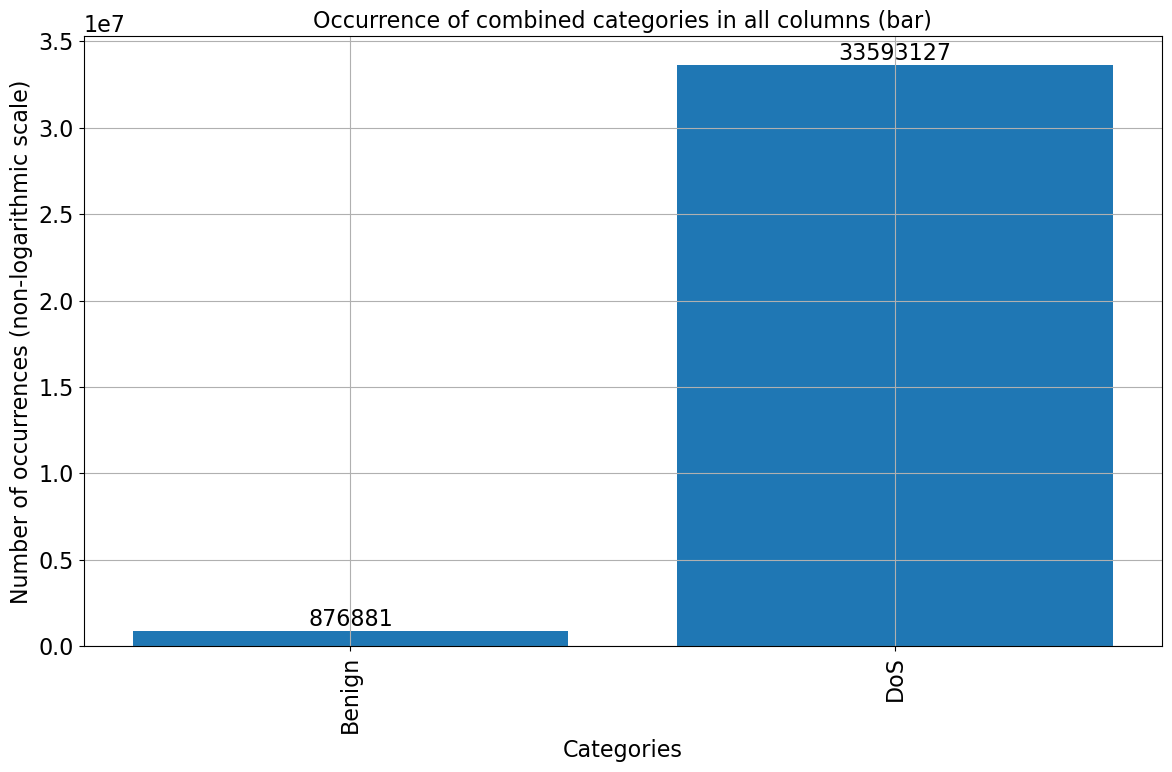

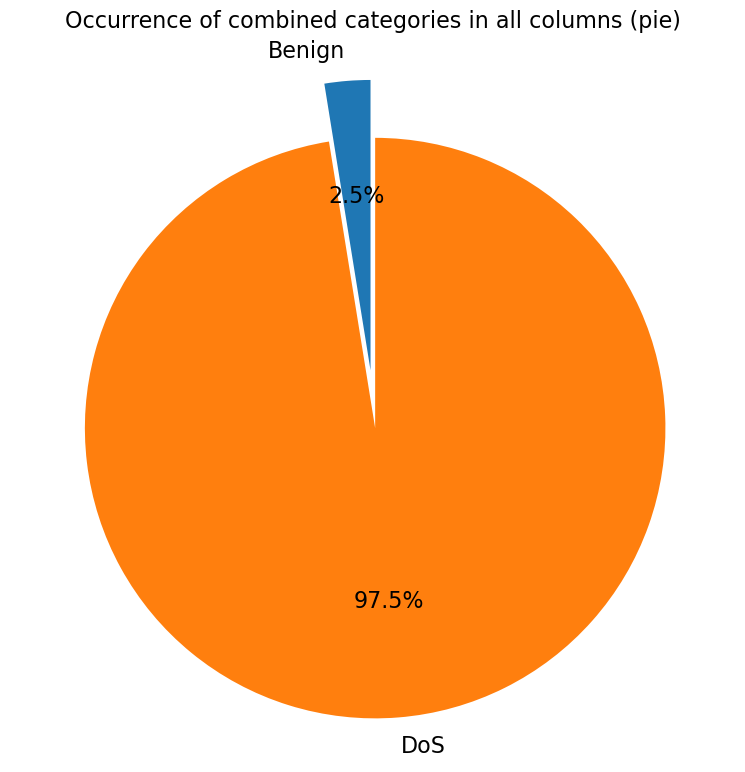

In [4]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(train_sets) + len(test_sets))

plot_bar_chart(count_label(train_sets, file_path=file_path), 'Occurrence of combined categories in all columns (bar)', 'Categories', 'Number of occurrences', 12, 8, model_repo, log_scale=False)
plot_pie_chart(count_label(train_sets, file_path=file_path), 'Occurrence of combined categories in all columns (pie)', 12, 8, model_repo)

Threshold:  3318595


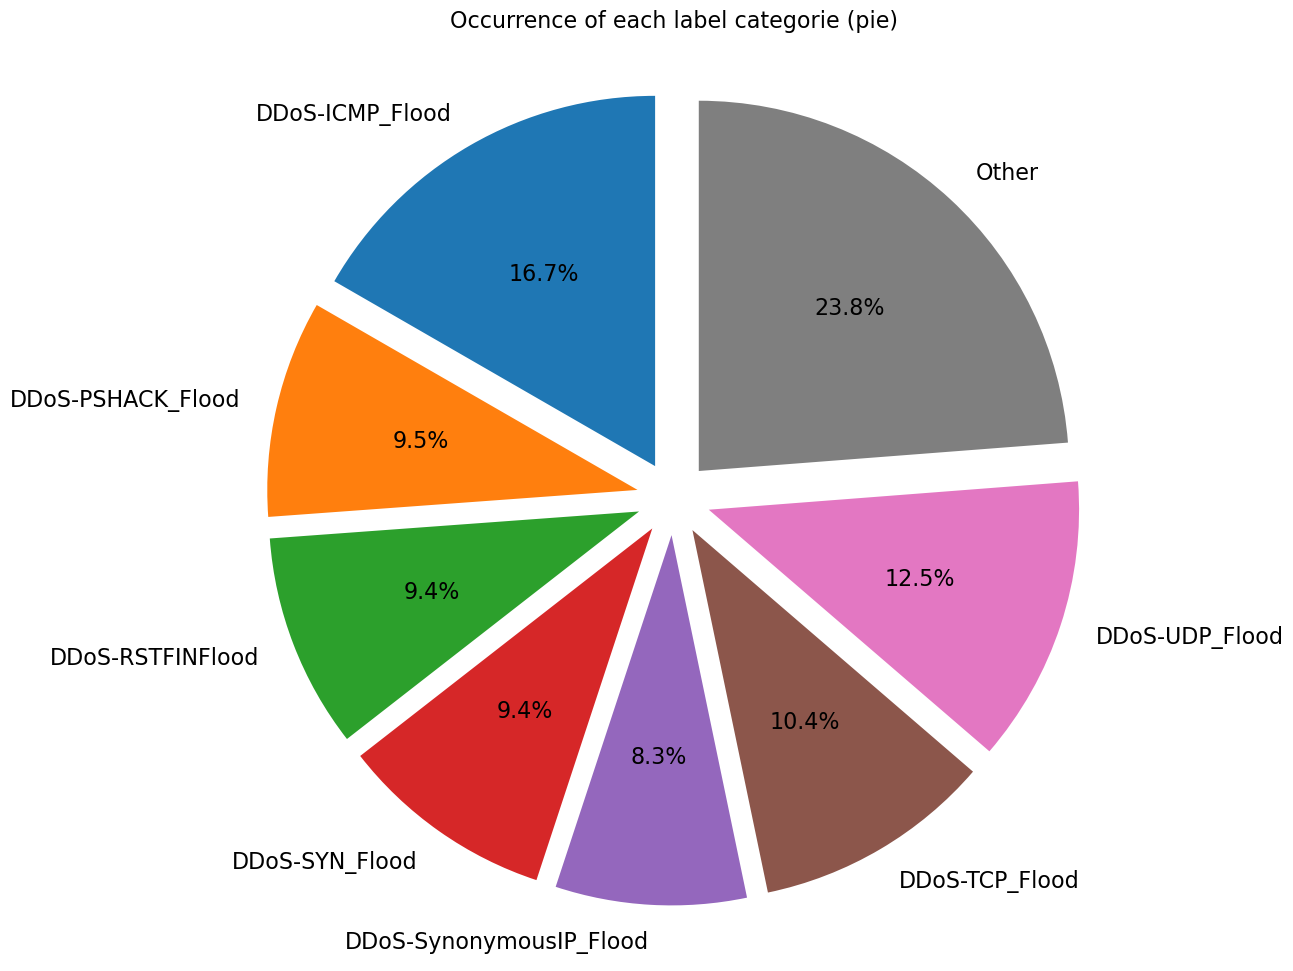

In [26]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
copy_train_sets = train_sets.copy()
copy_train_sets.extend(test_sets)

results = []
for dataset in copy_train_sets:
    df = pd.read_csv(file_path + dataset)
    class_counts = df['label'].value_counts()
    results.append(class_counts)
class_counts_combined = pd.concat(results)

# class_counts_combined.groupby(class_counts_combined.index).sum().head(len(class_counts_combined.groupby(class_counts_combined.index).sum()))
class_counts_combined = class_counts_combined.groupby(class_counts_combined.index).sum()
copy_class_counts_combined = class_counts_combined.copy()

# Select threshold from 30% of the most common label
threshold = class_counts_combined.sort_values(ascending=False).head(int(len(class_counts_combined) * 0.5)).min()

print('Threshold: ', threshold)

# Modifying class_counts_combined to only include labels above threshold and sum to 'Other' the labels below threshold
class_counts_combined = class_counts_combined[class_counts_combined > threshold]
class_counts_combined['Other'] = copy_class_counts_combined[copy_class_counts_combined <= threshold].sum()

class_counts_combined.head(len(class_counts_combined))

plt.figure(figsize=(15, 10))
plt.title('Occurrence of each label categorie (pie)')
plt.pie(class_counts_combined.groupby(class_counts_combined.index).sum().values, labels=class_counts_combined.groupby(class_counts_combined.index).sum().index, autopct='%1.1f%%', startangle=90, explode=[0.1]*len(class_counts_combined.groupby(class_counts_combined.index).sum()))
plt.tight_layout()
plt.grid()
plt.savefig(model_repo + 'Occurrence of each label categorie (pie)' + '.png')
plt.show()



## Define variables

In [4]:
performance_path = 'performance.csv'
file_path = '.\Files\\DoS\\'
model_path_binary = '.\\DoS_system_2_models\\Binary\\'
local_path = '.\\DoS_system_2_models\\'
model_path_all_classes = '.\\DoS_system_2_models\\All_classes\\'
after_build_csv = 'after_build_set_scaled.csv'

# Get path data
build_sets, after_build_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(build_sets) + len(after_build_sets))

# Get build datasets
build_nb = round(len(build_sets) * 0.8)
train_sets = build_sets[:build_nb]
# train_sets = train_sets[: round(len(train_sets) * 0.5)]
test_sets = build_sets[build_nb:]
# test_sets = test_sets[: round(len(test_sets) * 0.5)]

# Define different columns
X_columns = x_columns(read_csv_file(train_sets[0], path_to_datasets=file_path))
X_columns = X_columns[:-2]
print(len(X_columns))
y_column = 'label'
z_column = 'Binary'

95
46


# First model (DoS (DDoS and DoS) or Benign)

## Buiding models

In [9]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    {
        "Name": "Cat",
        "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "LIGHT",
        "Model": LGBMClassifier(random_state = 42)
    },
    {
        "Name": "GBoost",
        "Model": GradientBoostingClassifier(random_state = 42)
    },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    {
        "Name": "MLP",
        "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    },
]

In [ ]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_binary)
performance = get_or_define_performance_df(model_path_binary, performance_path)

# Load selected X columns
selected_X = pd.read_csv(model_path_binary+'selected_X_columns.csv').values

# Map selected X columns
selected_X = list(map(lambda x: x[0], selected_X))

# Buidling models
plotConfusionMatrix = True
figsizeConfusionMatrix = (10, 5)
saveConfusionMatrix = False
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], 'SF_'+model['Name'], train_sets, test_sets, file_path, performance, model_path_binary+'SF_', X_columns=selected_X, y_column=z_column, encoder=encoder, scaler=scaler, \
                                                     confusionMatrix=plotConfusionMatrix, saving=saveConfusionMatrix, pathToSave=model_path_binary+'SF_'+model['Name'], figsize=figsizeConfusionMatrix)

    # Save performance
    performance.to_csv(model_path_binary + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path_binary+'encoder.joblib')

#### Features importance

In [19]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": joblib.load(model_path_binary+'model_DT.joblib')
    },
    {
        "Name": "RF",
        "Model": joblib.load(model_path_binary+'model_RF.joblib')
    },
    {
        "Name": "XGB",
        "Model": joblib.load(model_path_binary+'model_XGB.joblib')
    },
    {
        "Name": "Cat",
        "Model": joblib.load(model_path_binary+'model_Cat.joblib')
    },
    {
        "Name": "LIGHT",
        "Model": joblib.load(model_path_binary+'model_LIGHT.joblib')
    },
    {
        "Name": "GBoost",
        "Model": joblib.load(model_path_binary+'model_GBoost.joblib')
    },
    {
        "Name": "Adaboost",
        "Model": joblib.load(model_path_binary+'model_Adaboost.joblib')
    },
]

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 146.94it/s]


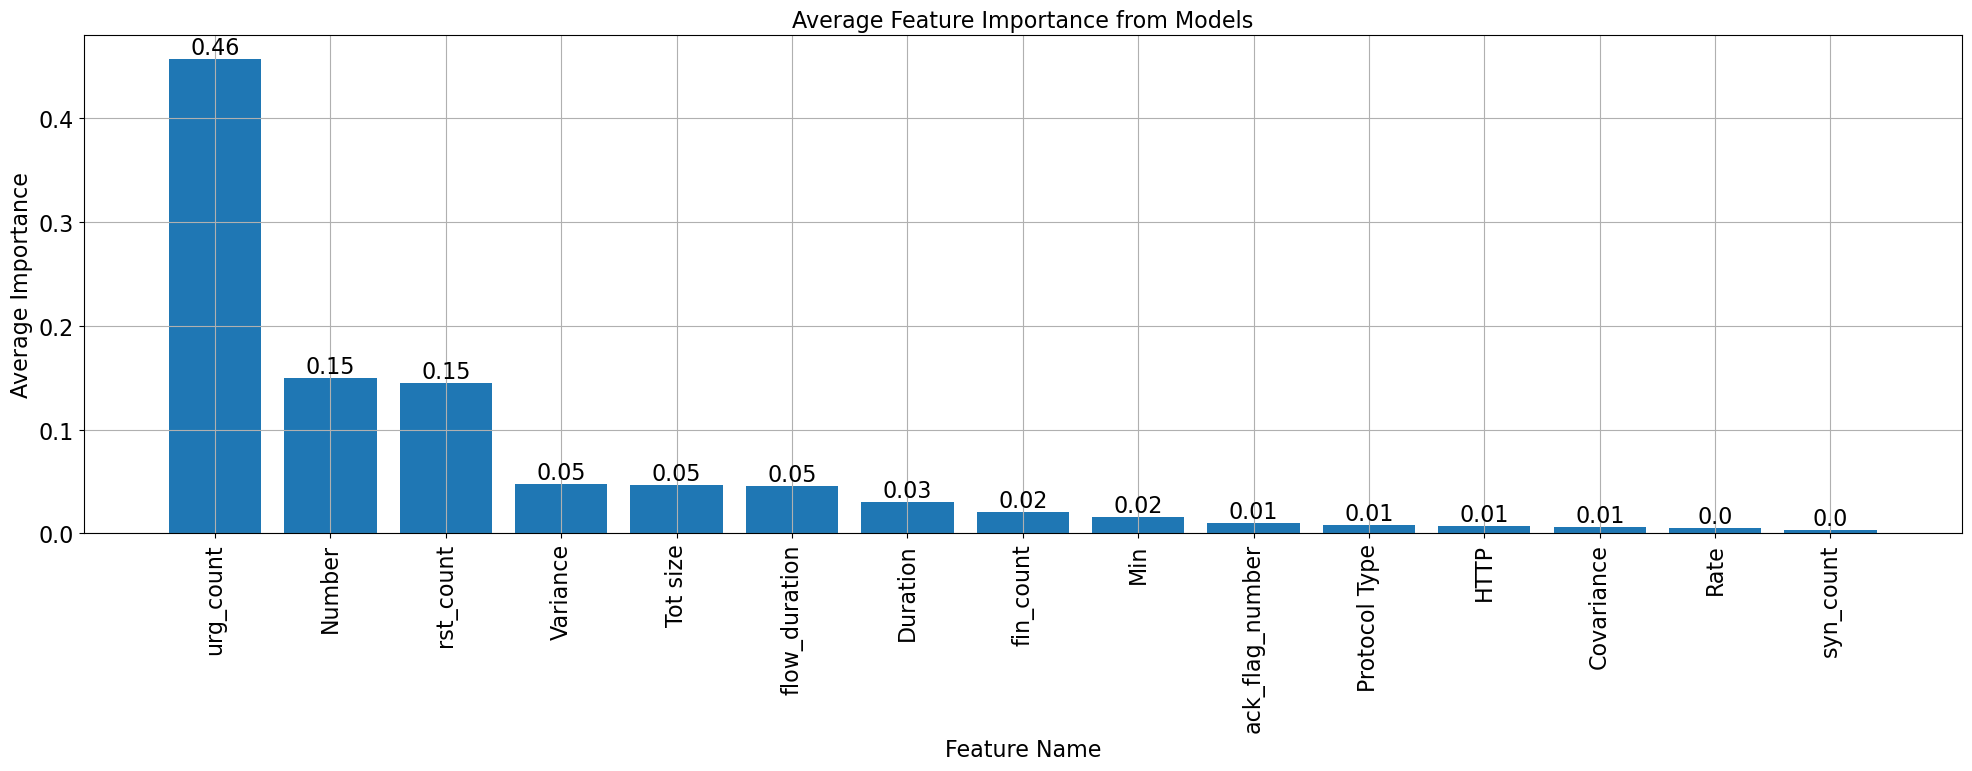

[0.4568657  0.60692552 0.75202892 0.79961342 0.84592415 0.89161594
 0.92226211 0.9431362  0.95895932 0.96912531 0.97707905 0.98406144
 0.99059349 0.99545236 0.99861412 0.99984151 0.99992927 0.9999914
 0.99999721 1.         1.         1.        ]


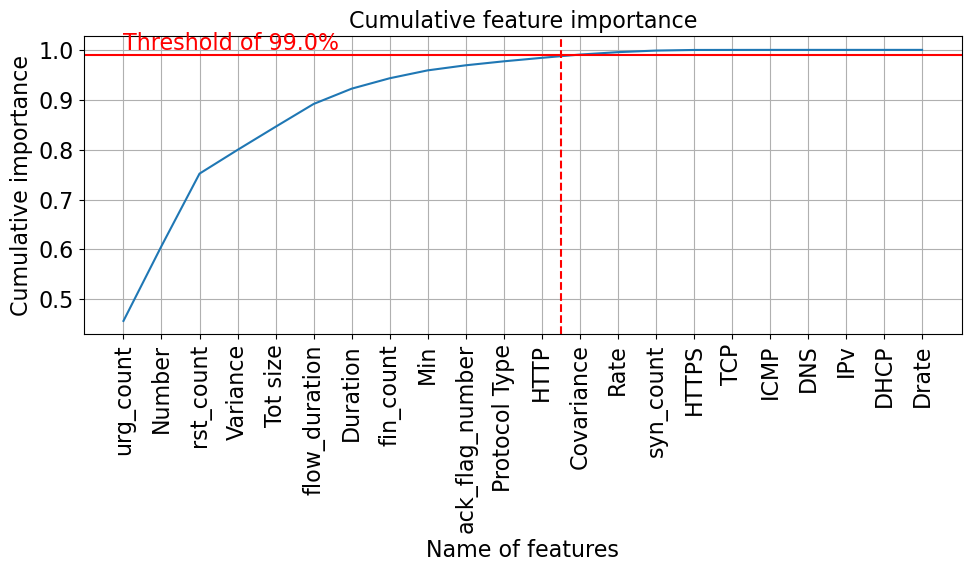

            Feature  Average Importance
0         urg_count            0.348003
1            Number            0.114303
2         rst_count            0.110528
5          Variance            0.036246
6          Tot size            0.035276
7     flow_duration            0.034804
9          Duration            0.023344
10        fin_count            0.015900
12              Min            0.012053
16  ack_flag_number            0.007744
18    Protocol Type            0.006059
19             HTTP            0.005319


In [20]:
# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, X_columns, model_path_binary, all_features=True, figsize=(20, 8))
average_importance_df.to_csv(model_path_binary+'feature_importance.csv', index=False)
average_importance_df.to_csv('.\\resultats\\DoS_2_models\\Binary\\feature_importance.csv', index=False)

# Load feature importance dataframe
average_importance_df = pd.read_csv(model_path_binary+'feature_importance.csv')
# print(average_importance_df.head(average_importance_df.size))

# Remove features with correlation > 0.80
threshold = 0.80
features_with_threshold_corr = remove_features_with_correlation_and_feature_importance(read_csv_file(train_sets[0], file_path)[X_columns], average_importance_df, model_path_binary, figsize=(20, 8), threshold=threshold)
# print(features_with_threshold_corr.head(features_with_threshold_corr.size))

selected_X = select_features_by_importance(features_with_threshold_corr['Feature'].values, features_with_threshold_corr['Average Importance'].values, model_path_binary, threshold_percentage=0.99)
pd.DataFrame(selected_X).to_csv(model_path_binary+'selected_X_columns.csv', index=False)
# print(selected_X)

filtered_df = average_importance_df[average_importance_df['Feature'].isin(selected_X)]
print(filtered_df.head(filtered_df.size))

# Define and fit scaler
#scaler = MinMaxScaler()
#for train_set in tqdm(train_sets):
#    scaler.fit(read_csv_file(train_set, file_path)[selected_X])

In [21]:
models = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
]

Index(['urg_count', 'Number', 'rst_count', 'Variance', 'Tot size',
       'flow_duration', 'Duration', 'fin_count', 'Min', 'ack_flag_number',
       'Protocol Type', 'HTTP'],
      dtype='object')
itr: 1
['urg_count']
Training DecisionTreeClassifier...
Accuracy with CV: 0.9967278318125606
Training RandomForestClassifier...
Accuracy with CV: 0.9967378588856579
Training ExtraTreesClassifier...
Accuracy with CV: 0.9968381296166315
Training XGBoostClassifier...
Accuracy with CV: 0.9965373174237107
Training LightGBMClassifier...
Accuracy with CV: 0.9962298205153916
Training CatBoostClassifier...
Accuracy with CV: 0.9962298205153916
                        Accuracy  Precision    Recall  F1 Score  \
Model                                                             
ExtraTreesClassifier    0.996857   0.964923  0.970482  0.967685   
DecisionTreeClassifier  0.996740   0.962890  0.970269  0.966549   
RandomForestClassifier  0.996670   0.962881  0.968699  0.965771   
XGBoostClassifier       0.9965

TypeError: unhashable type: 'list'

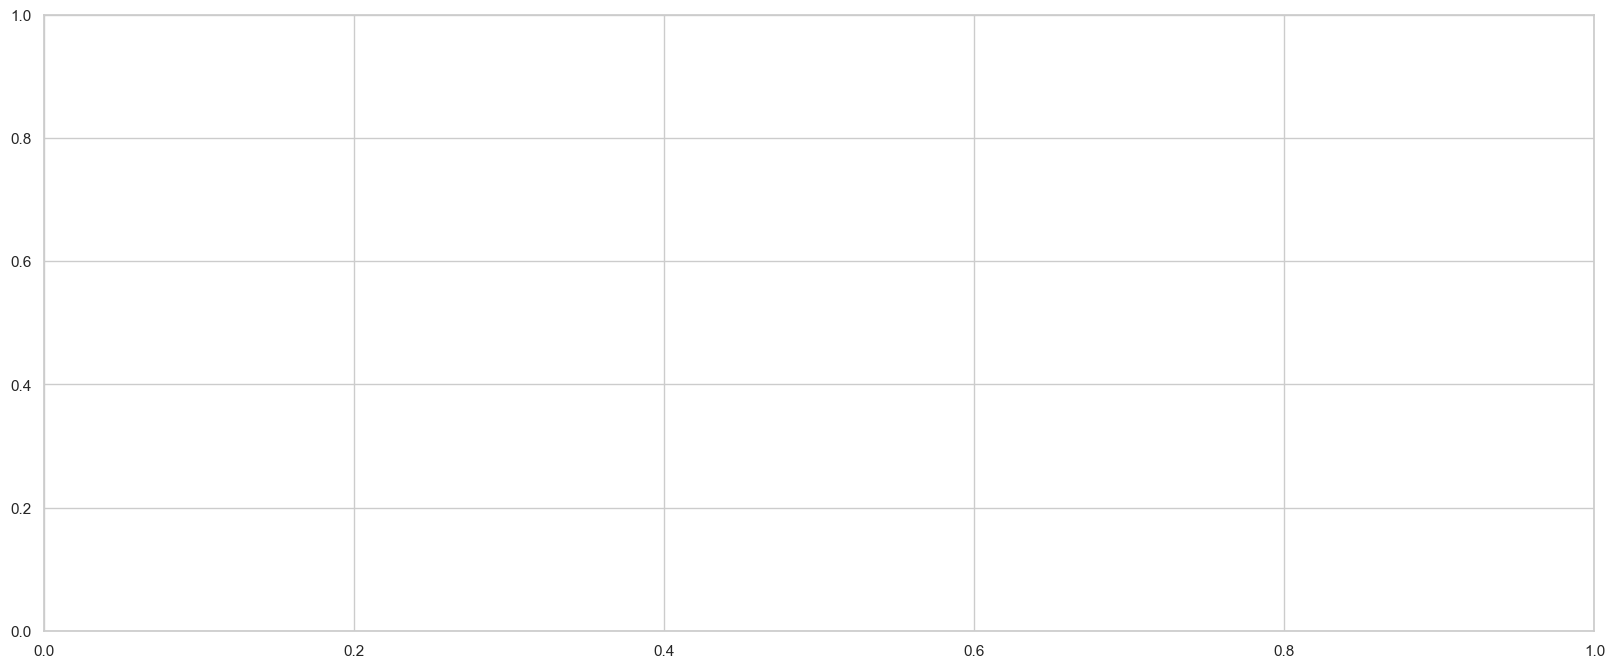

In [23]:
from select_best_feature_combination import *

# Initial setup and loading the dataset
dataset = read_csv_file(train_sets[0], file_path)
# for file in train_sets[1:1]:
#     dataset = pd.concat([dataset, read_csv_file(file, file_path)], ignore_index=True)
dataset.sample(10000, random_state=42).reset_index(drop=True)

corr_max = 0.8
final_features_df = pd.DataFrame(columns=['Model', 'Num_Features', 'Optimal_Features_Count', 'Optimal_Feature'])


from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Data Preprocessing
# Separate features (X) and target variable (y)
# Choose X with selected X
X = dataset[selected_X]
y = dataset['Binary']

# Apply MinMax scaling to the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display the first few rows of the scaled features and encoded target variable to verify the transformation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_encoded_df = pd.Series(y_encoded, name='Binary_Encoded')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_encoded, test_size=0.3, random_state=42)
print(X_train.columns)

# Define figure and axes according to the number of models
# fig, axs = plt.subplots(len(models), 2, figsize=(20, 6 * len(models)))

# Define the number of features 
led=0
born_min=1
born_max=len(X_scaled_df.columns)
CategoryList = ['DoS', 'Benign']

resAccuracy, resF1score = plotResultsvsNumberofFeatures(filtered_df, CategoryList, X_train, X_test, y_train, y_test, born_min, born_max, led)

# Print the results to verify outputs
print("Accuracy Results:", resAccuracy)
print("F1 Score Results:", resF1score)

# plotAccuracyF1score(resAccuracy, resF1score, filtered_df)

for idx, model in enumerate(models):
    print(f"Processing model: {model['Name']}")

    best_features, top_combinations_df = select_best_feature_combination(model['Model'], X_train, X_test, y_train, y_test, feature_list=X_scaled_df.columns, cv=5, scoring='accuracy', top_n=10, startk=1)

    print("Best Feature Combination:", best_features)
    print("Top Combinations Data Frame:")
    print(top_combinations_df)

    # # Plot best feature combination
    # plt.figure(figsize=(20, 8))
    # plt.bar(top_combinations_df['Feature Combination'], top_combinations_df['Training Accuracy'], label='Training Accuracy', color='blue')
    # plt.bar(top_combinations_df['Feature Combination'], top_combinations_df['Accuracy'], label='Accuracy', color='red')
    # plt.bar(top_combinations_df['Feature Combination'], top_combinations_df['F1 Score'], label='F1 Score', color='purple')
    # plt.bar(top_combinations_df['Feature Combination'], top_combinations_df['Precision'], label='Precision', color='green')
    # plt.bar(top_combinations_df['Feature Combination'], top_combinations_df['Recall'], label='Recall', color='orange')
    # plt.title(f"Top {len(top_combinations_df)} Feature Combinations for {model['Name']}")
    # plt.xlabel("Feature Combination")
    # plt.ylabel("Scores")
    # plt.xticks(rotation=90)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()



plt.tight_layout()
plt.show()

In [24]:
if len(selected_X) > 10:
    new_selected_X = selected_X[:10]
else:
    new_selected_X = selected_X
    
# Pairplot of selected features
pairplot_X = new_selected_X.copy()
plt.figure(figsize=(20, 10))
sns.pairplot(read_csv_file(train_sets[0], file_path)[pairplot_X].sample(1000, random_state=42).reset_index(drop=True))
plt.title('Pairplot Selected Features')
plt.grid()
plt.tight_layout()
plt.savefig(model_path_binary+'Pairplot_selectedFeatures.png')
plt.show()

# Correlation matrix of selected features
plt.figure(figsize=(20, 10))
sns.heatmap(read_csv_file(train_sets[0], file_path)[pairplot_X].corr(), annot=True)
plt.title('Correlation Matrix Selected Features')
plt.grid()
plt.tight_layout()
plt.savefig(model_path_binary+'CorrelationMatrix_selectedFeatures.png')
plt.show()

# -------

# Pairplot of top combinations df
plt.figure(figsize=(20, 10))
sns.pairplot(read_csv_file(train_sets[0], file_path)[top_combinations_df].sample(1000, random_state=42).reset_index(drop=True))
plt.title('Pairplot Top Combinations Features')
plt.grid()
plt.tight_layout()
plt.savefig(model_path_binary+'Pairplot_topCombinationsFeatures.png')
plt.show()

# Correlation matrix of top combinations df
plt.figure(figsize=(20, 10))
sns.heatmap(read_csv_file(train_sets[0], file_path)[top_combinations_df].corr(), annot=True)
plt.title('Correlation Matrix Top Combinations Features')
plt.grid()
plt.tight_layout()
plt.savefig(model_path_binary+'CorrelationMatrix_topCombinationsFeatures.png')
plt.show()

##### Some plots

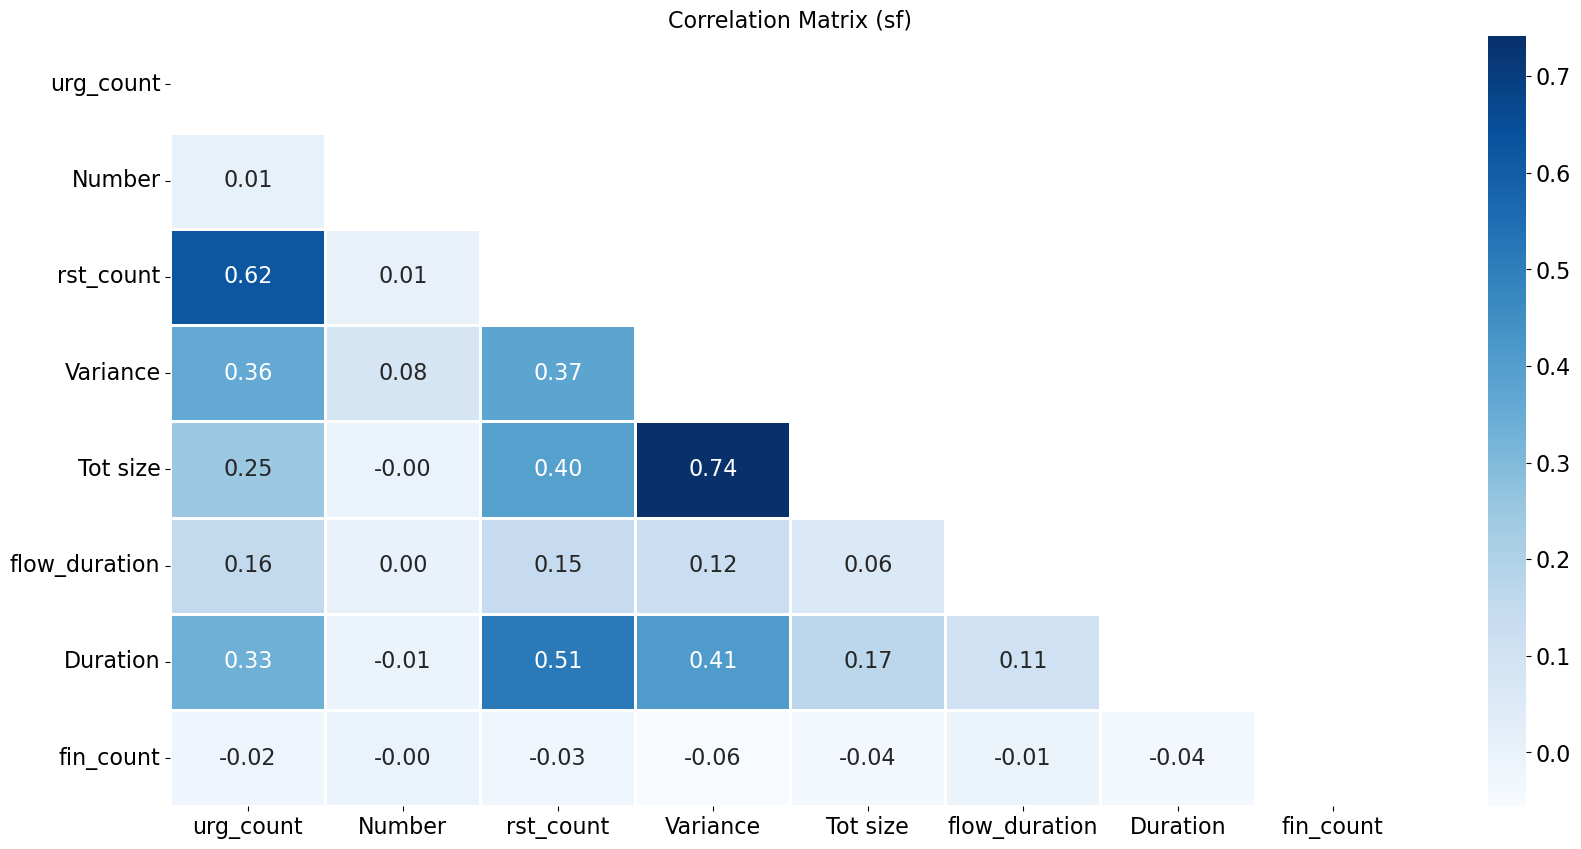

<Figure size 2000x1000 with 0 Axes>

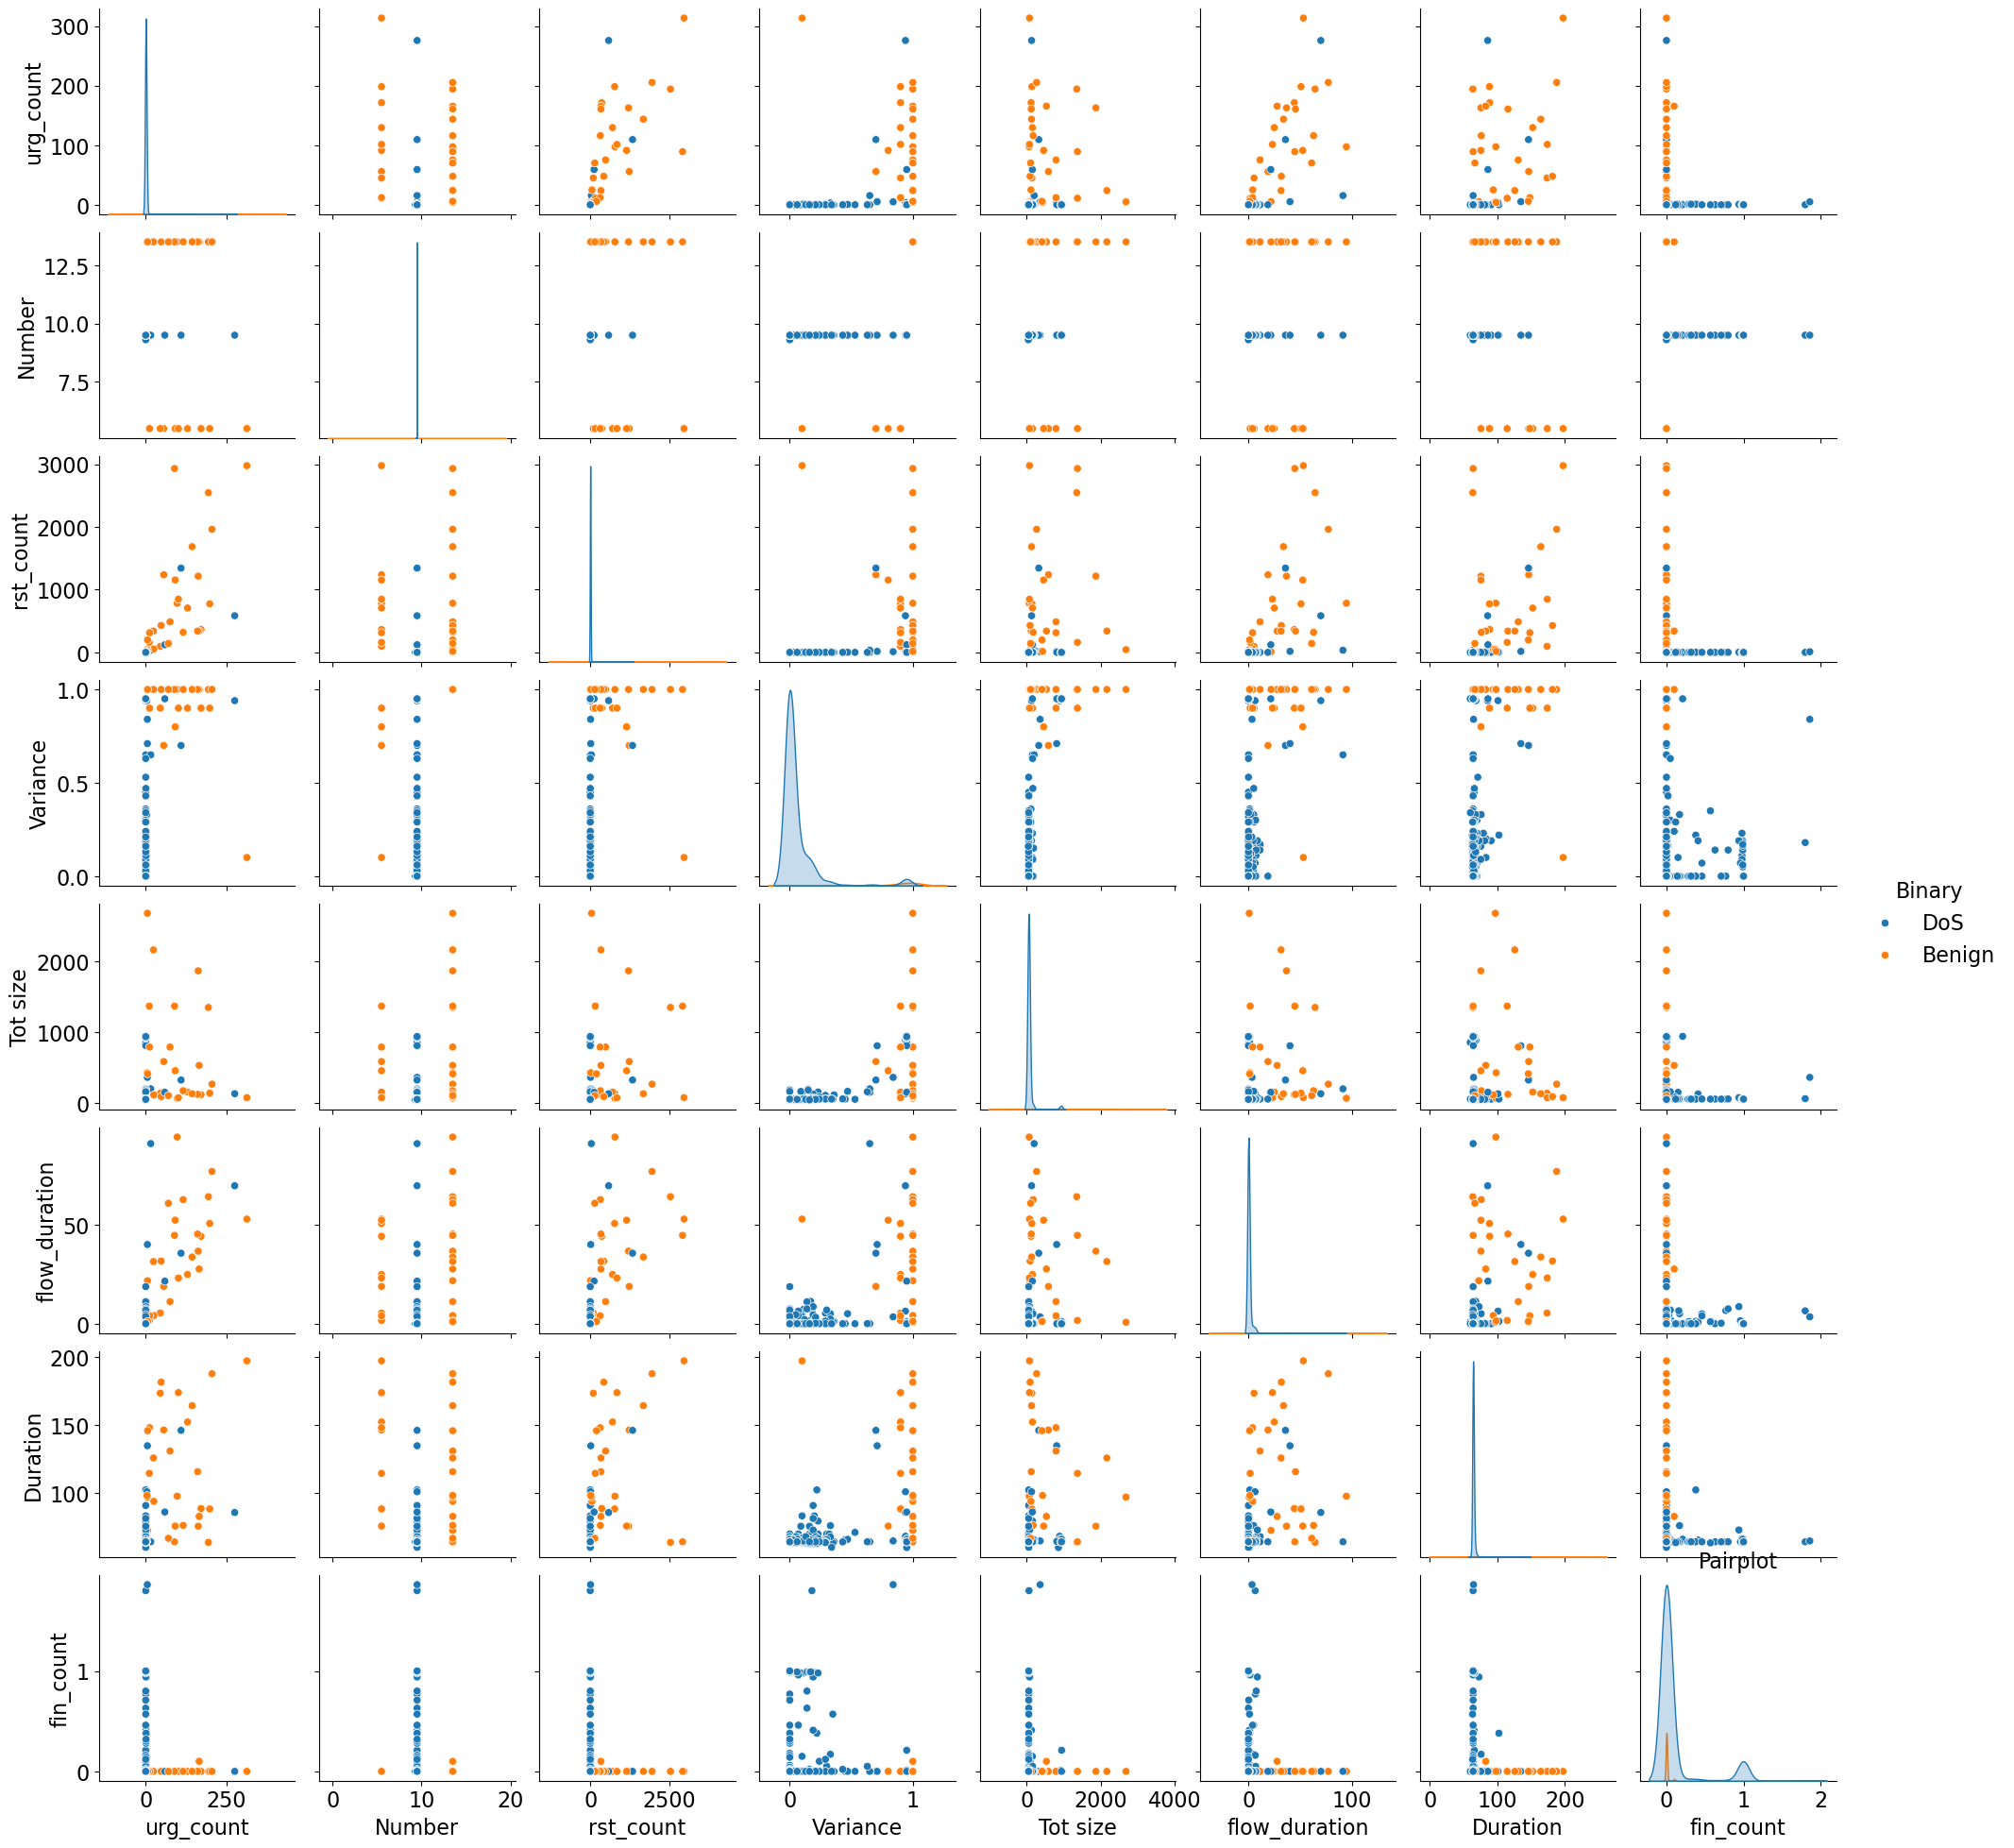

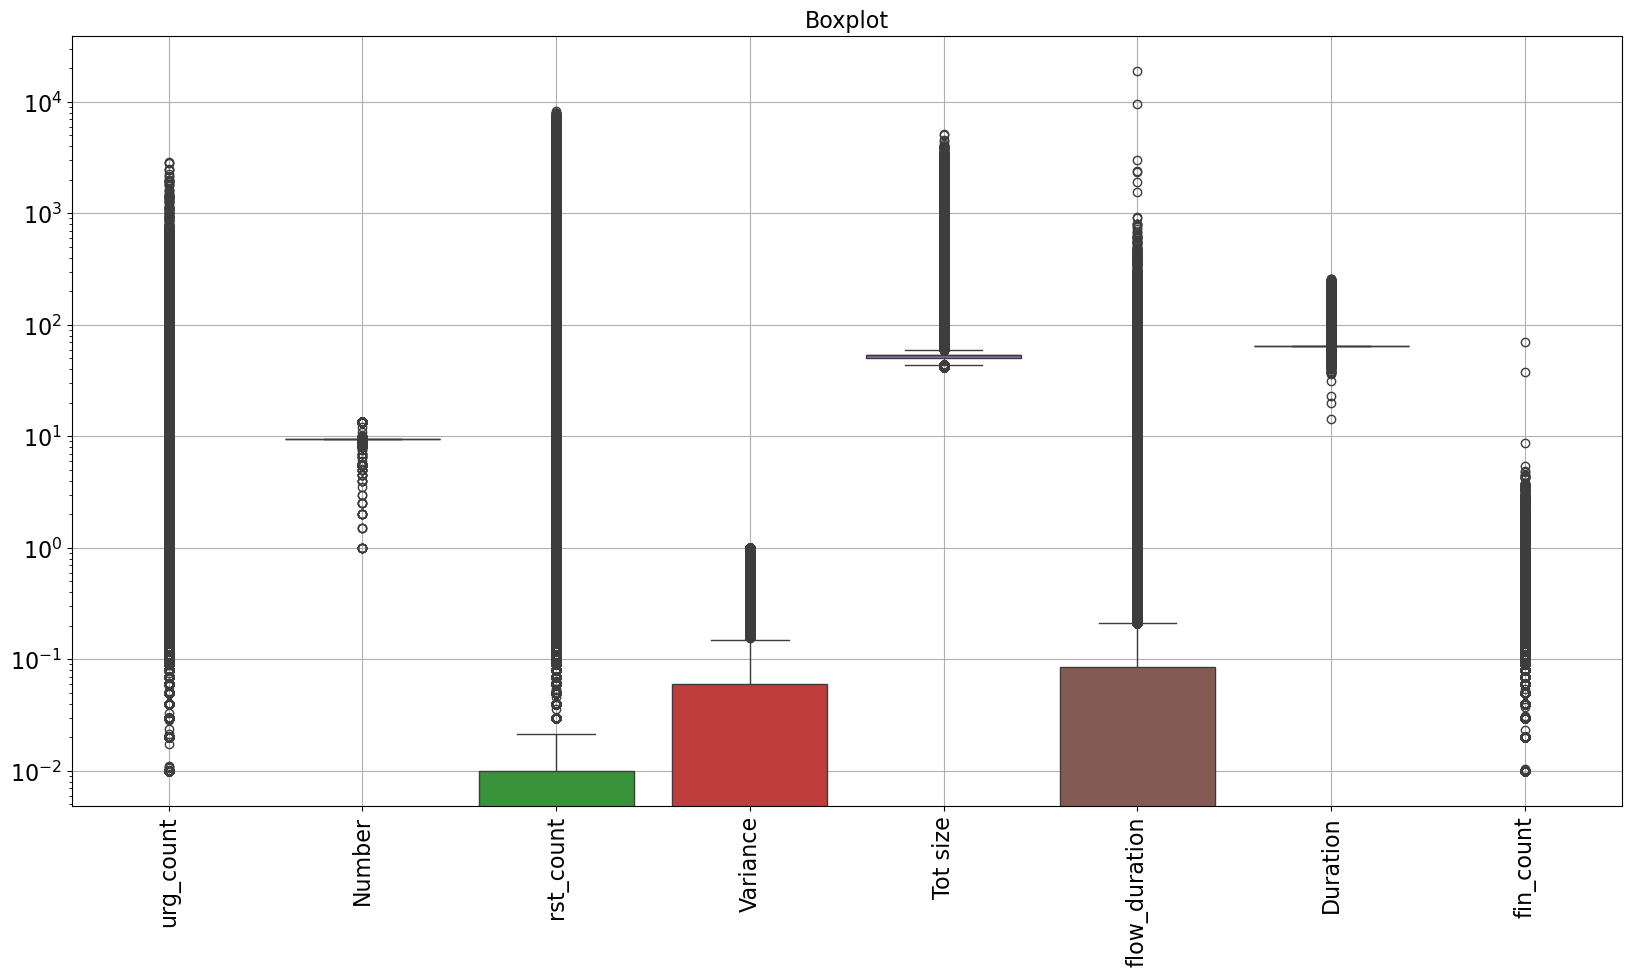

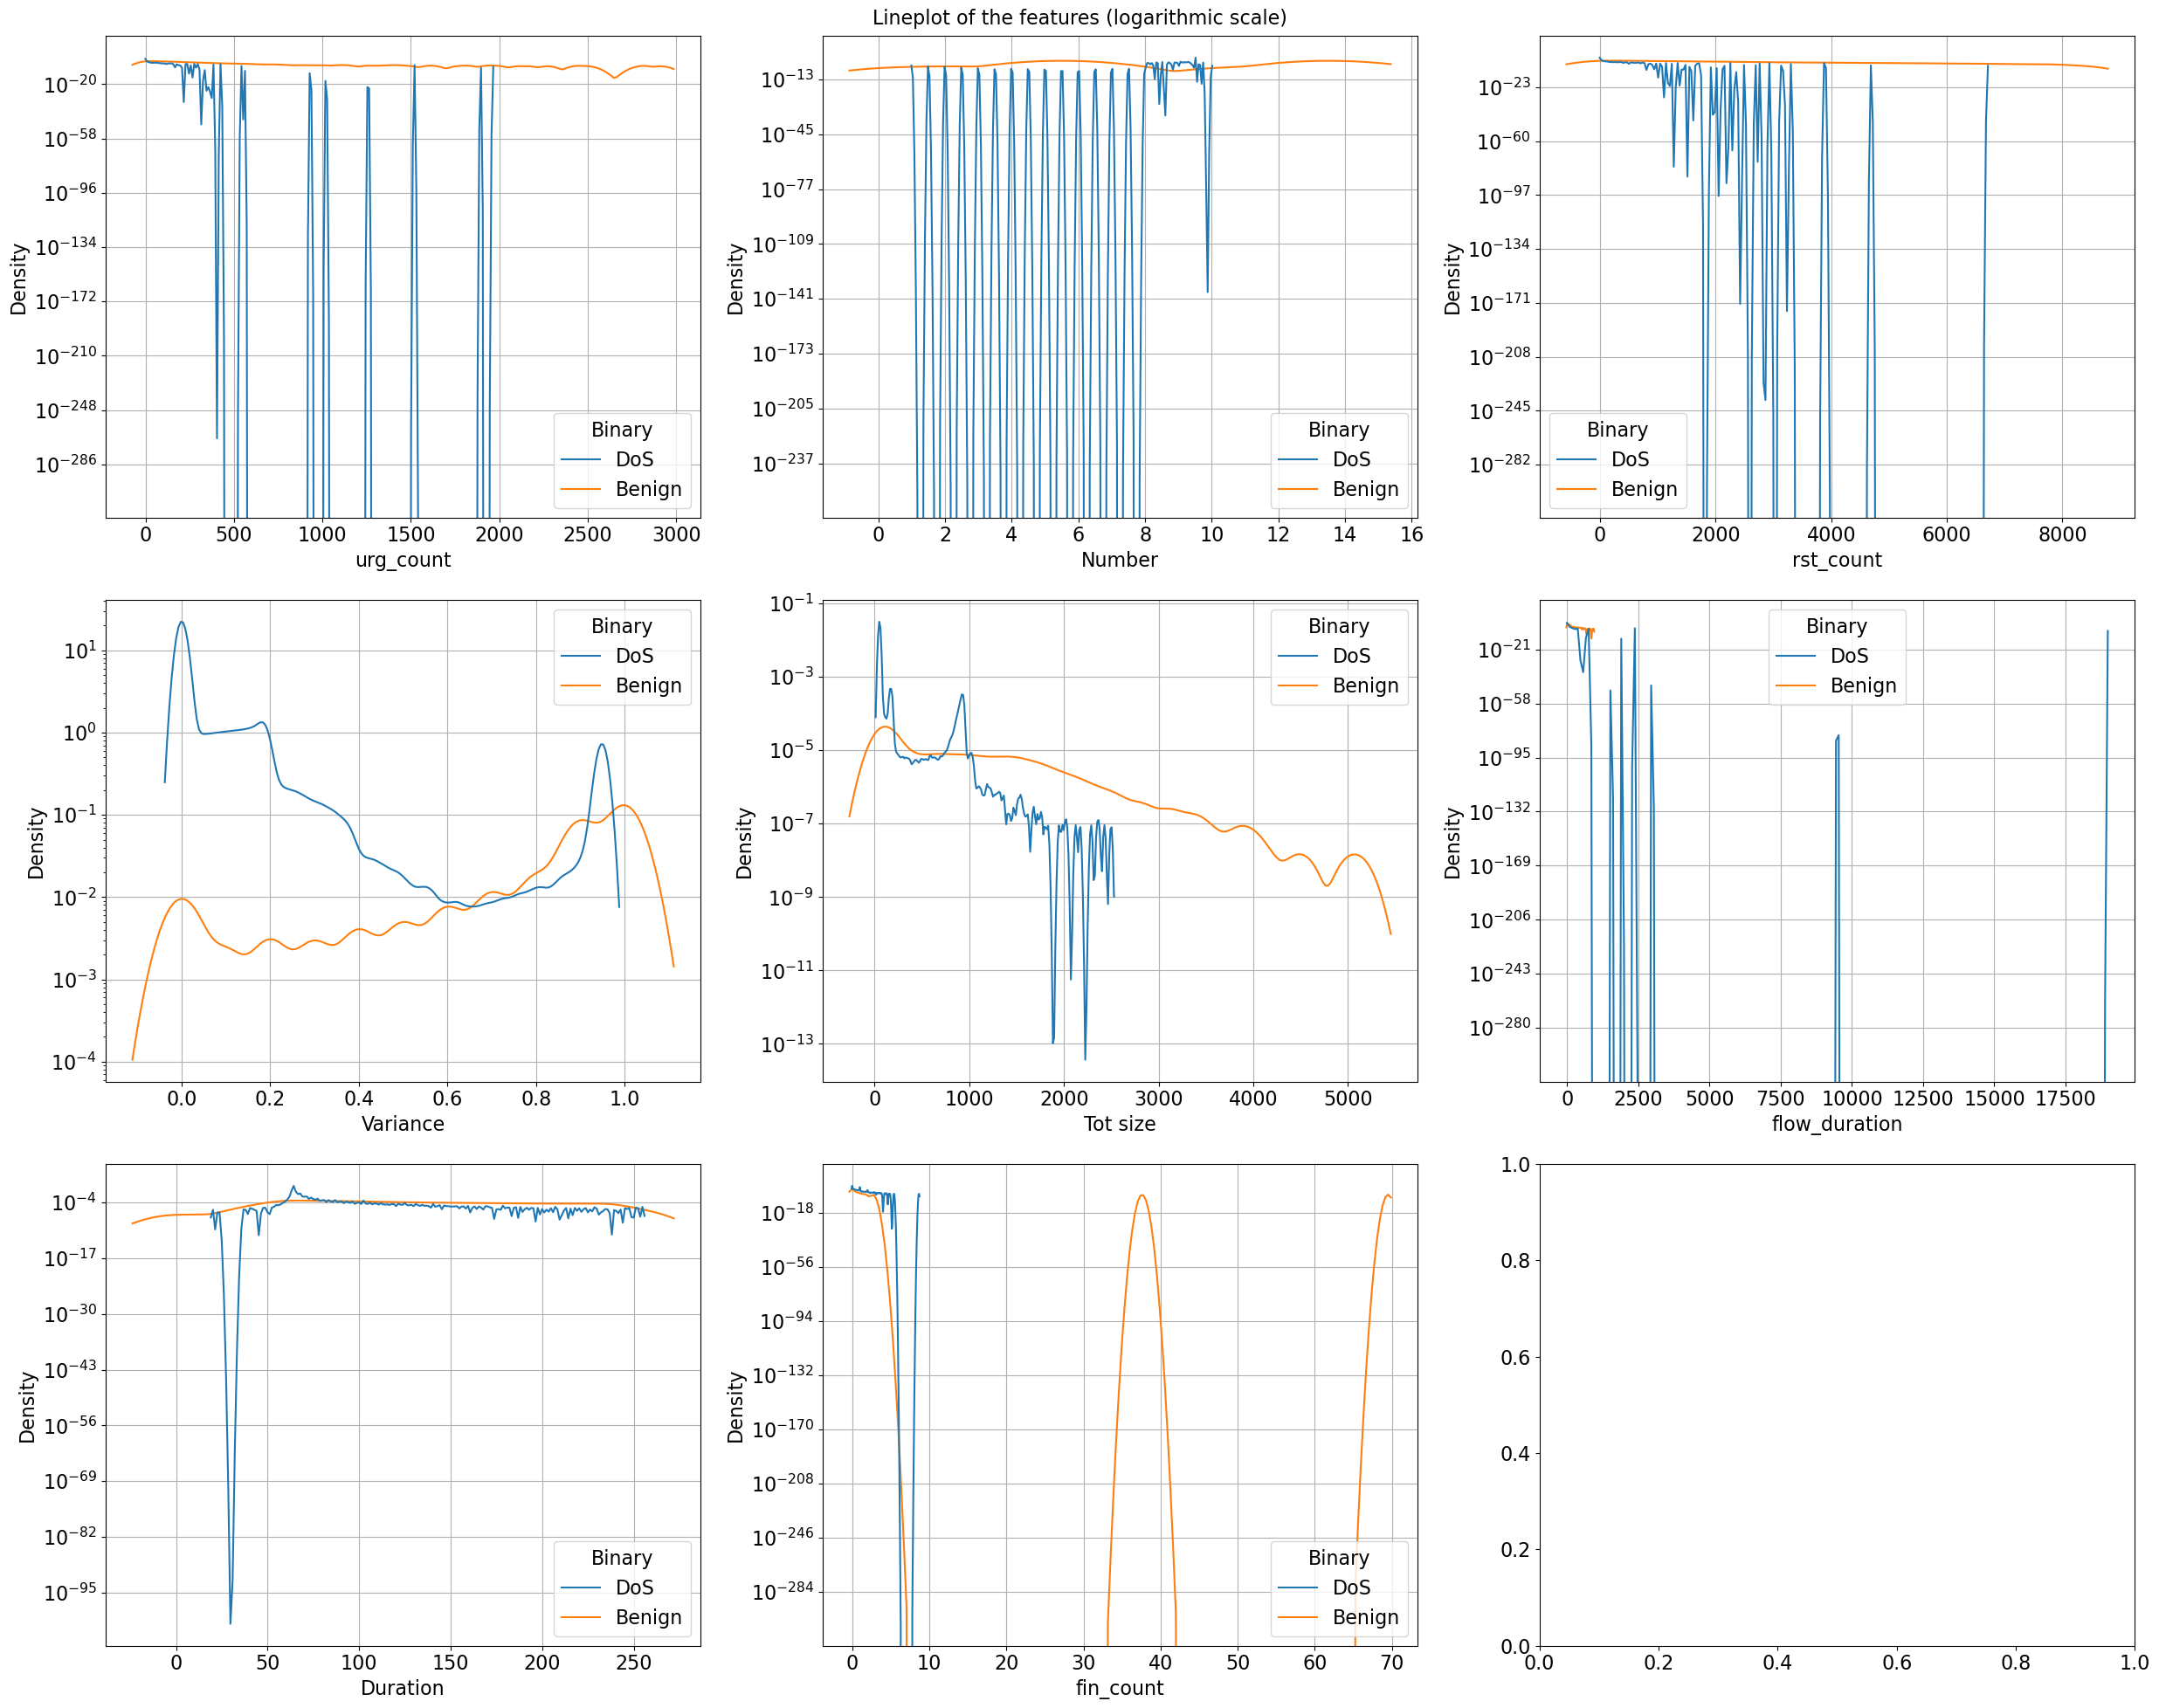

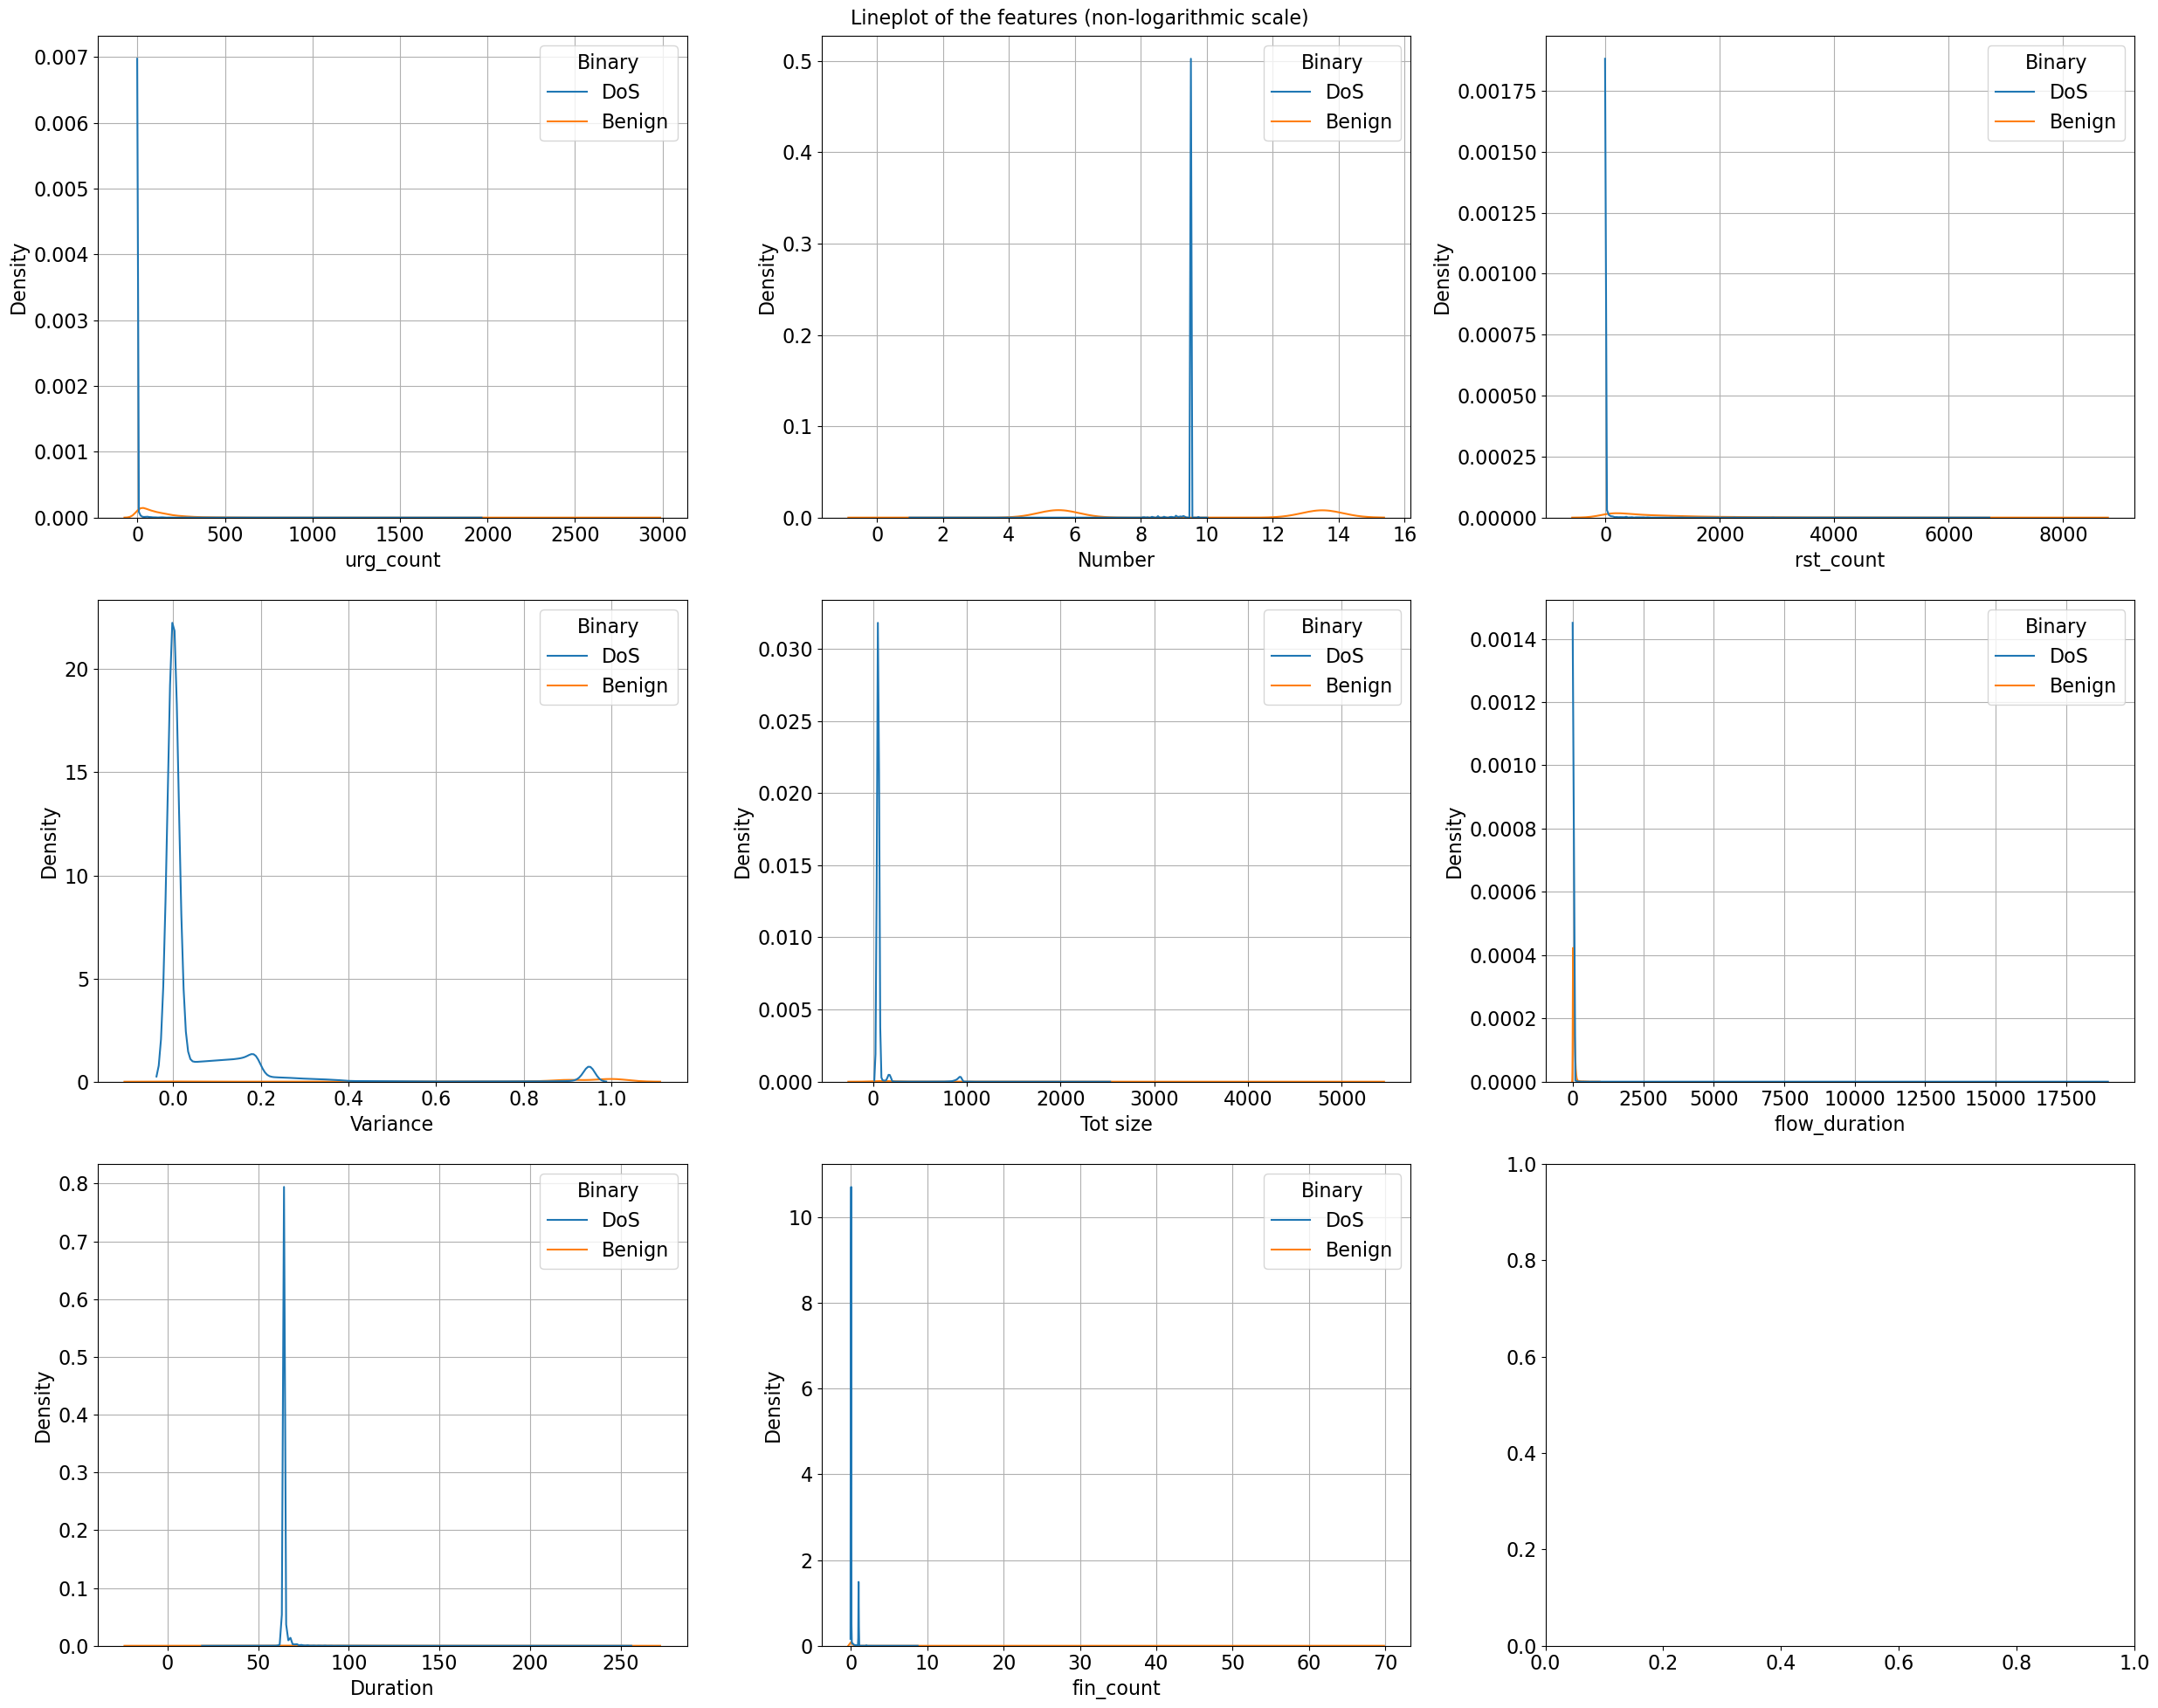

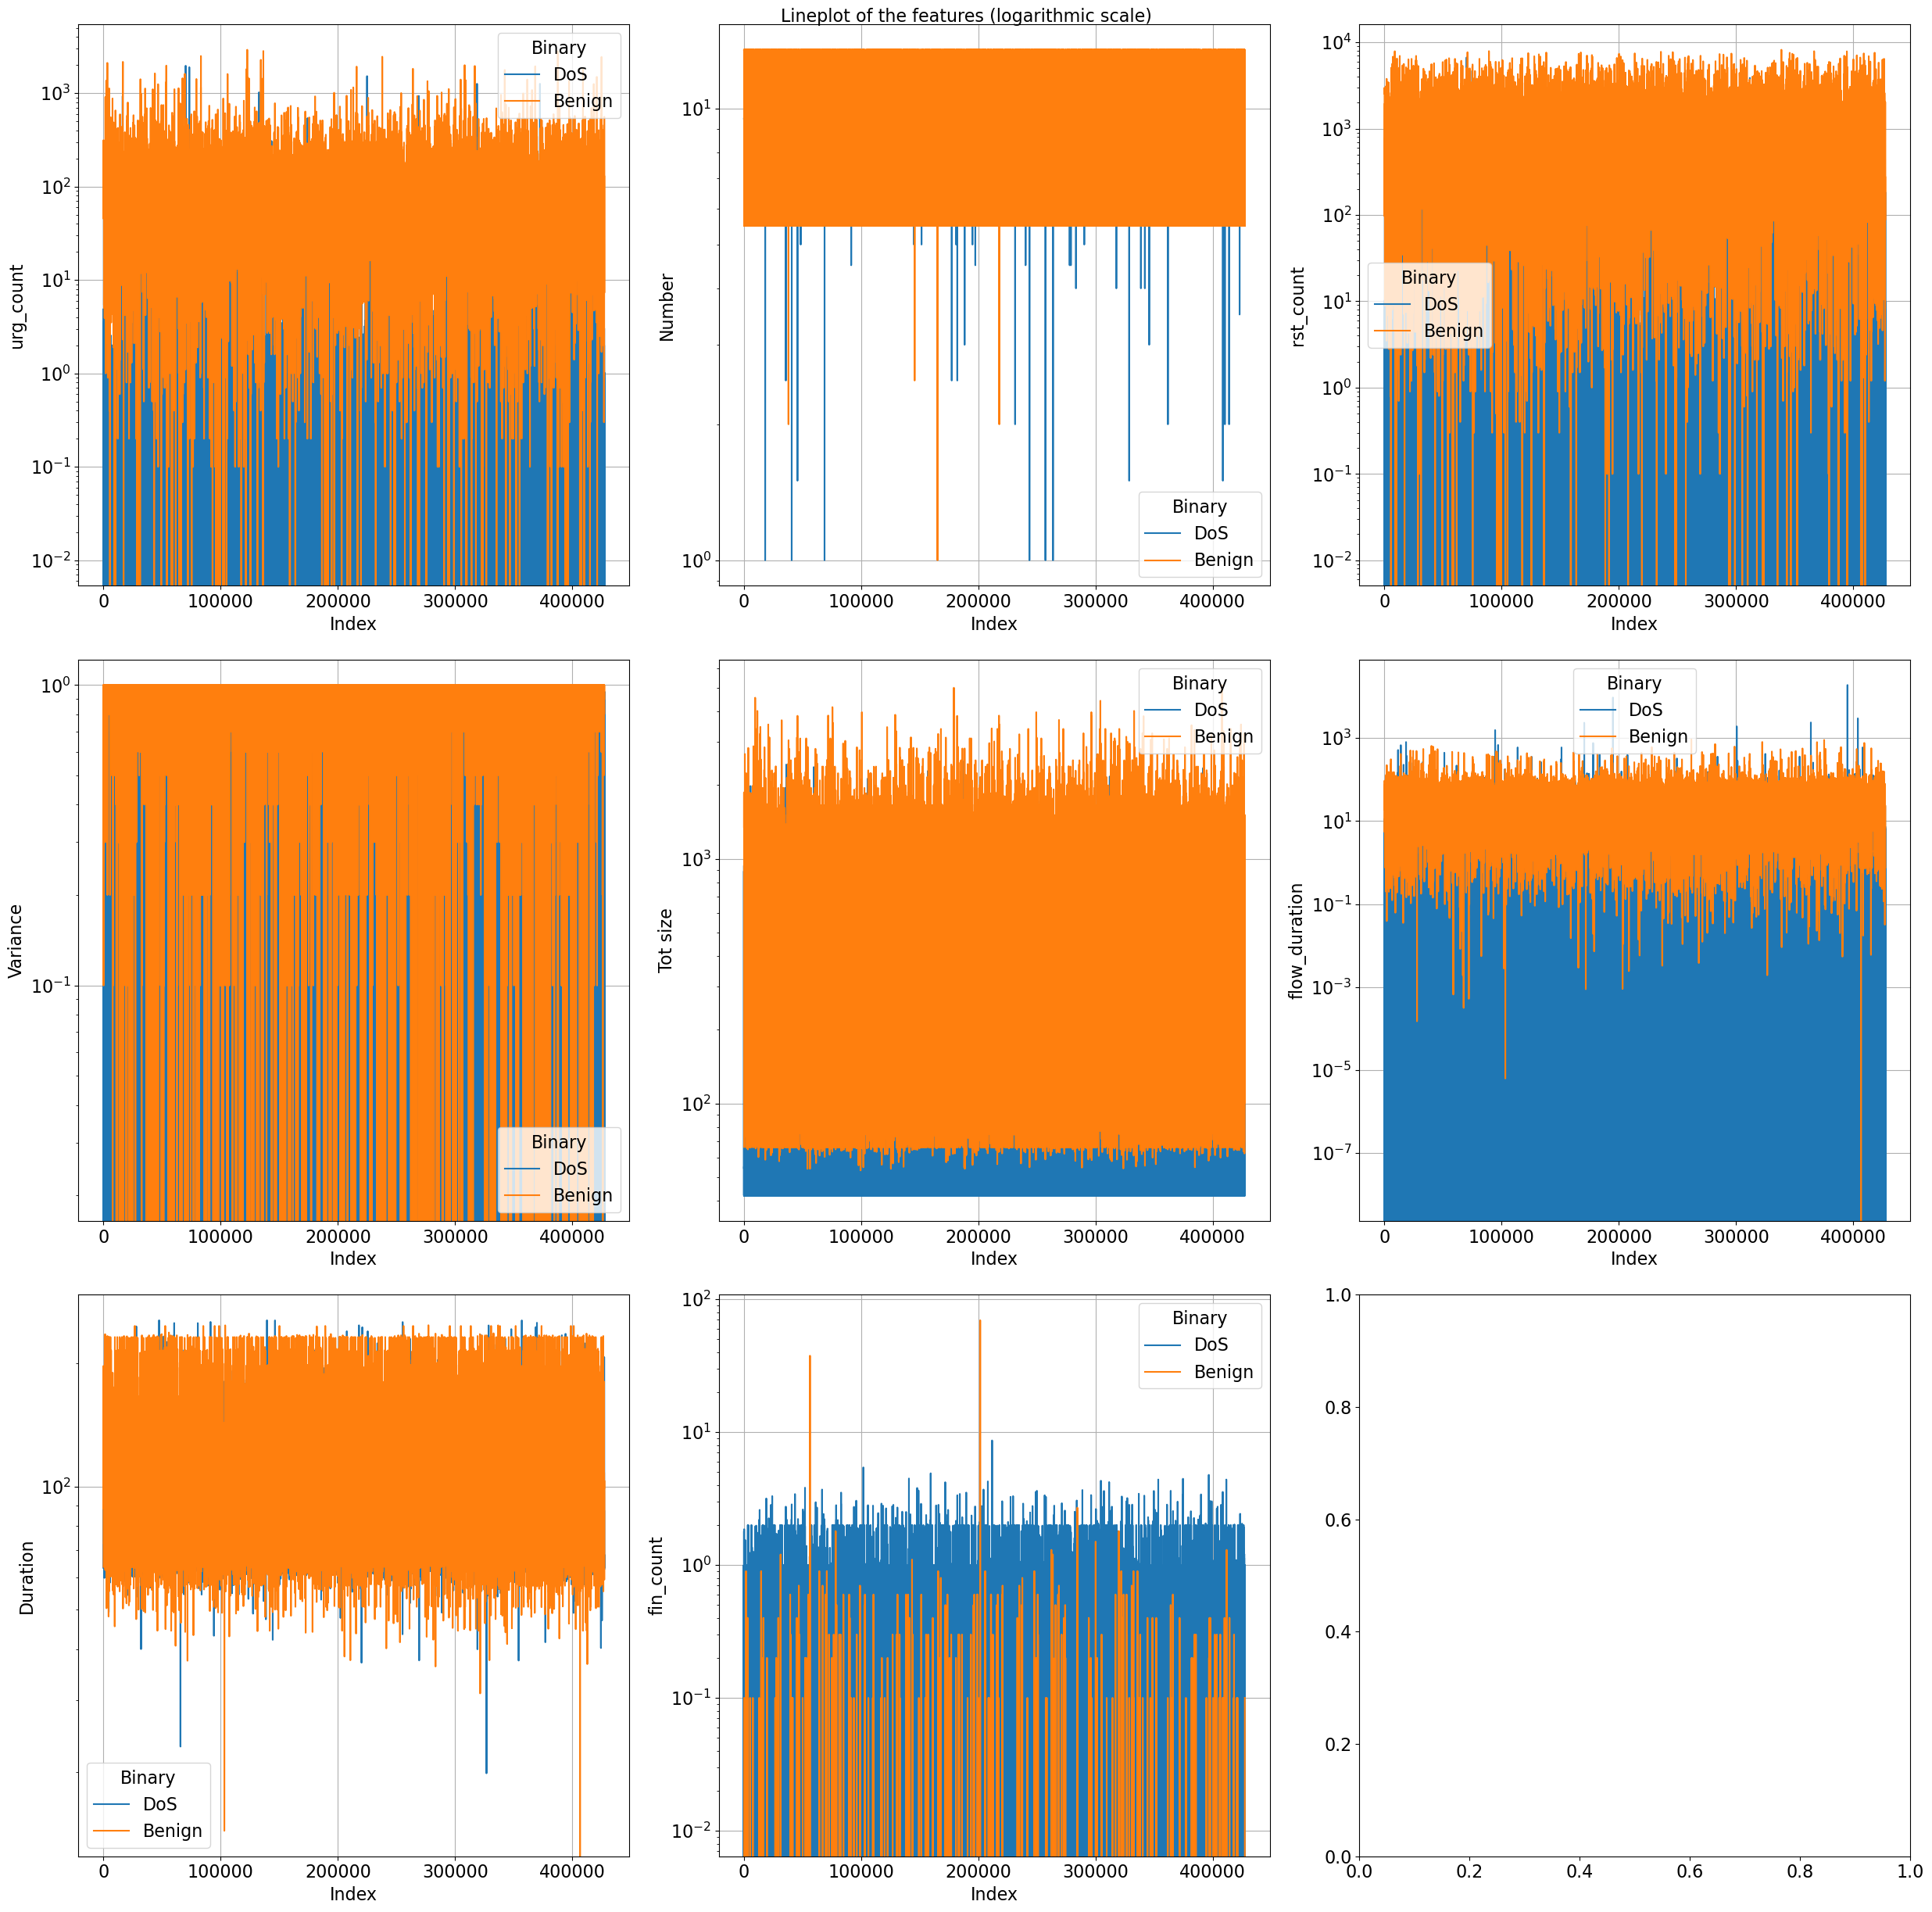

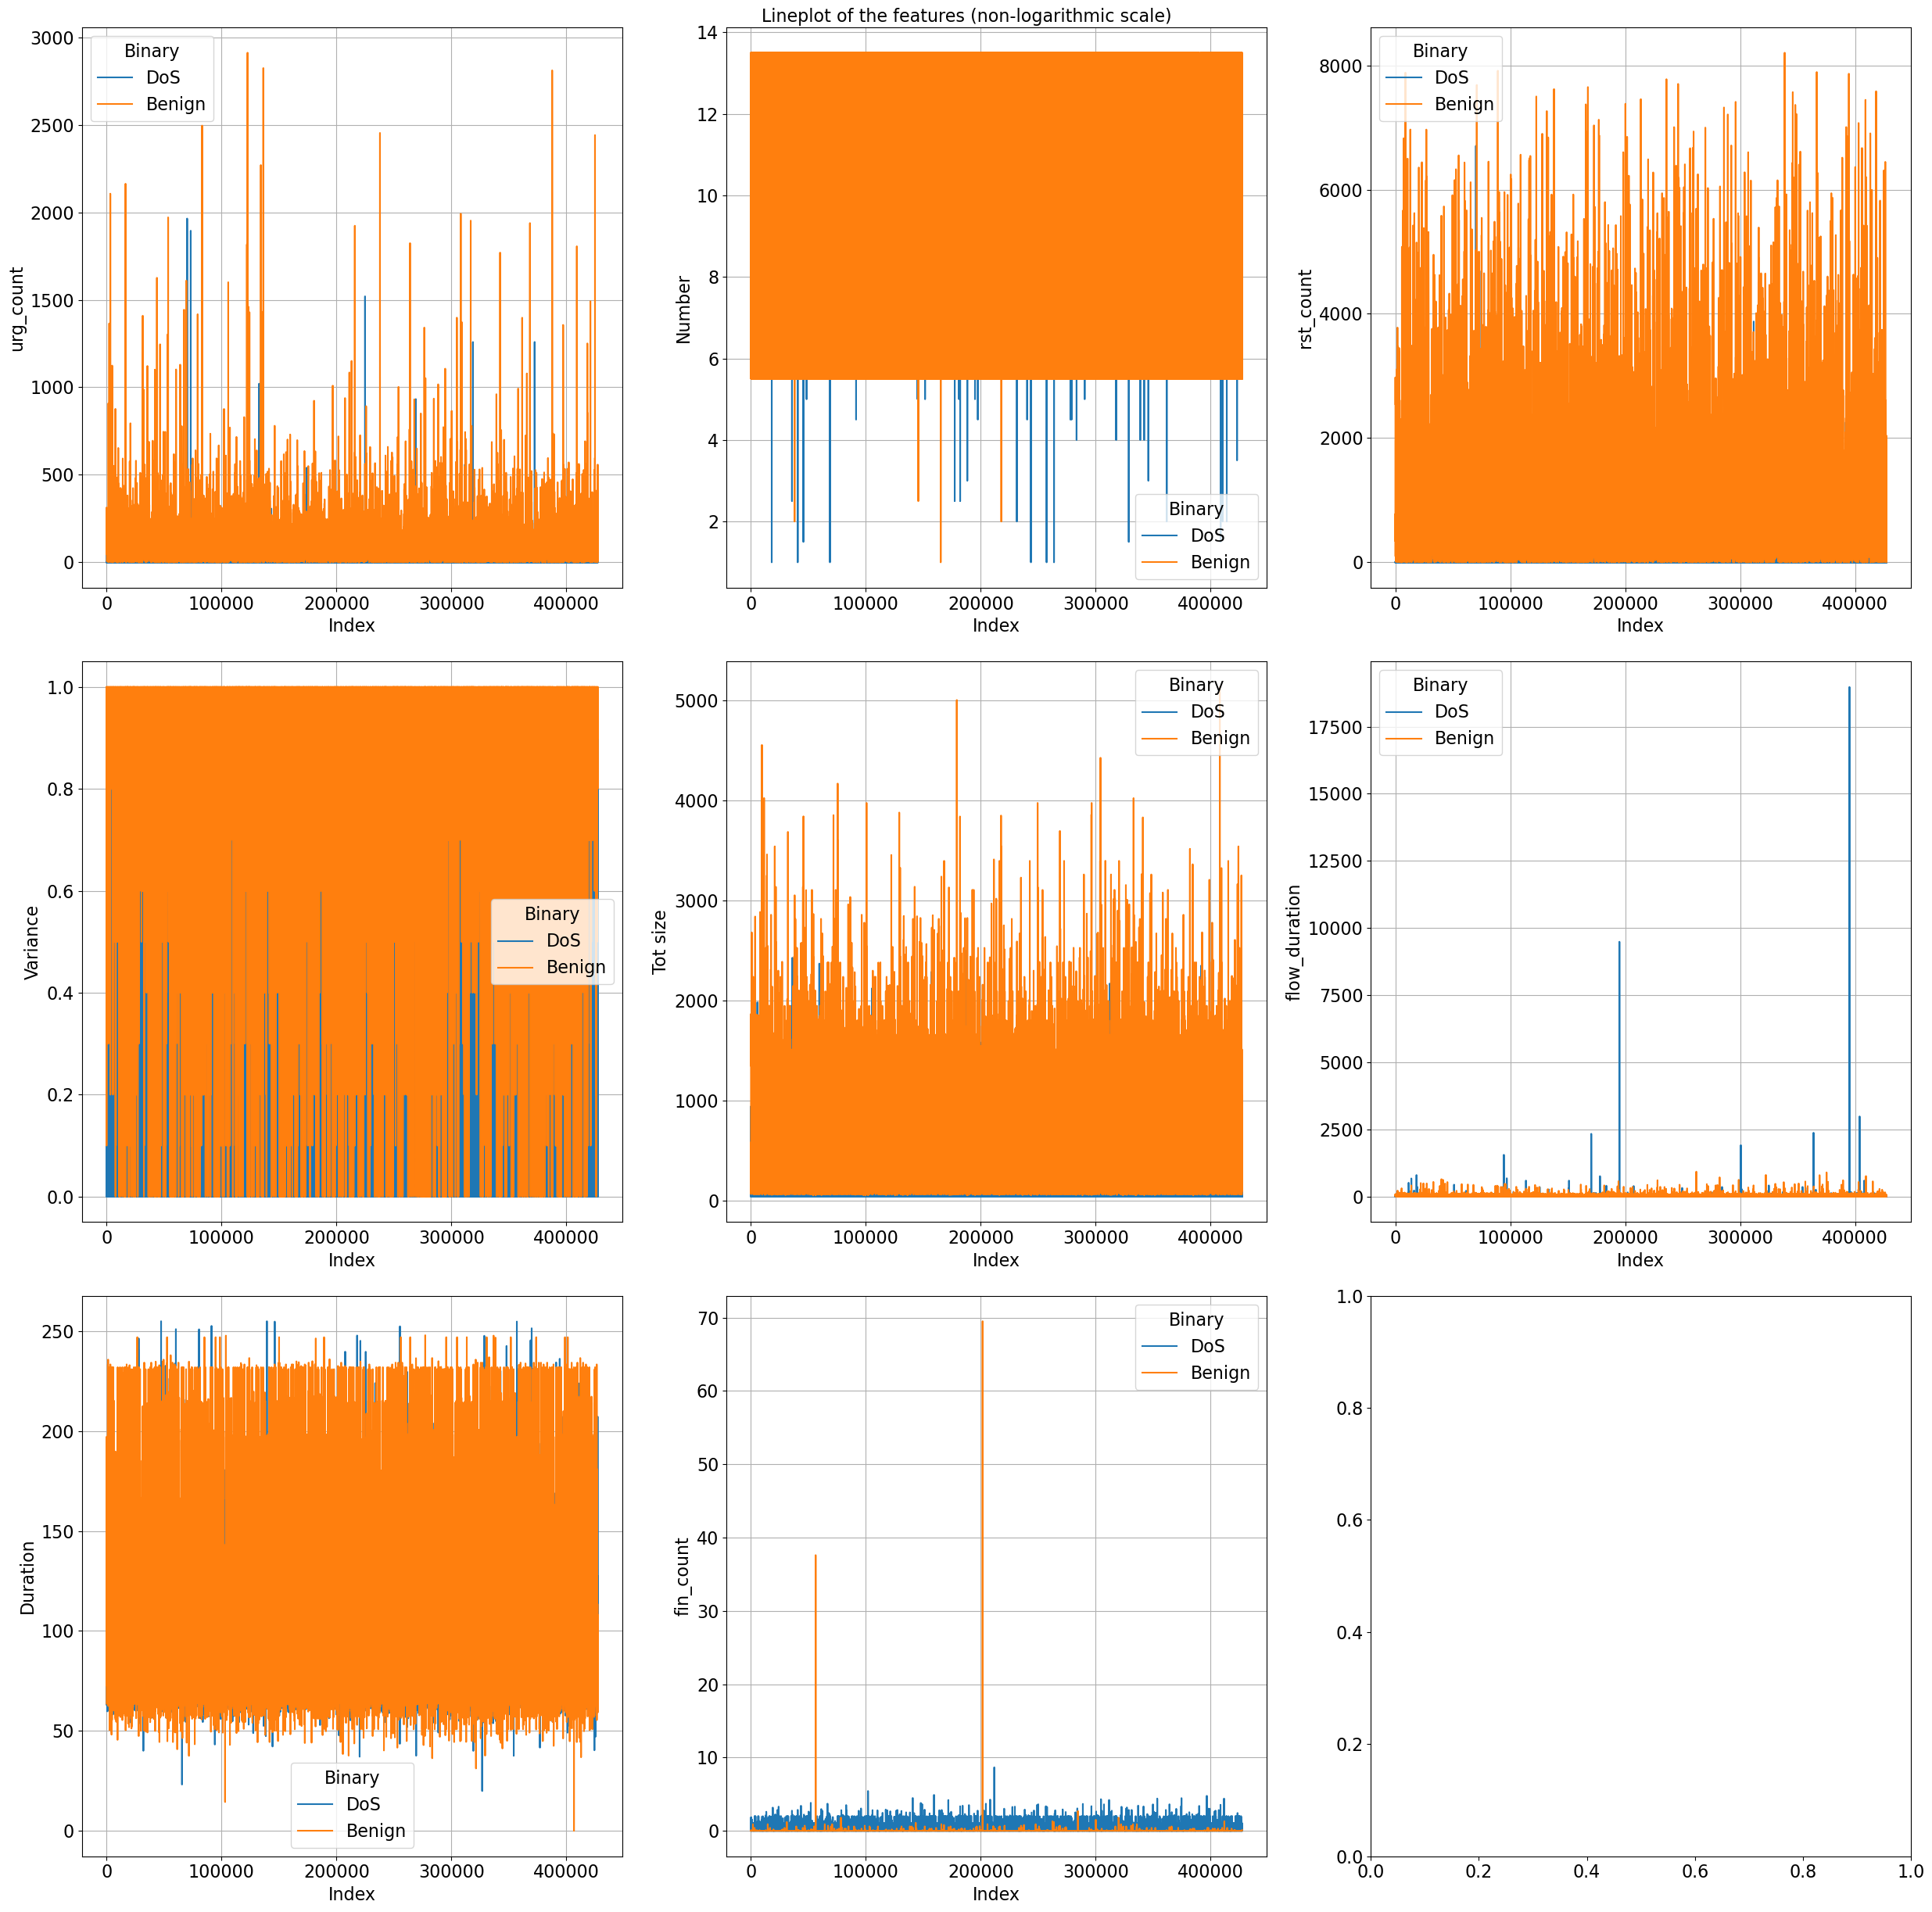

In [18]:
import matplotlib as mpl

# Setting the parameters as suggested in the error message
mpl.rcParams['agg.path.chunksize'] = 10000

# Load selected X columns
selected_X = pd.read_csv(model_path_binary+'selected_X_columns.csv').values

# Map selected X columns
selected_X = list(map(lambda x: x[0], selected_X))

plot_correlation_matrix(read_csv_file(train_sets[0], file_path)[selected_X], model_path_binary+'Correlation Matrix (sf).png', 'Correlation Matrix (sf)', lower=True)
# plot_correlation_matrix(read_csv_file(train_sets[0], file_path)[X_columns], model_path_binary+'Correlation Matrix (all features).png', 'Correlation Matrix (all features)', labels=False, lower=True)

if len(selected_X) > 10:
    new_selected_X = selected_X[:10]
else:
    new_selected_X = selected_X
    
pairplot_binary = new_selected_X.copy()
pairplot_binary.append('Binary')
plot_pairplot(read_csv_file(train_sets[0], file_path)[pairplot_binary].iloc[:1000], model_path_binary+'Pairplot.png', 'Binary', 'Pairplot')

plot_boxplot(read_csv_file(train_sets[0], file_path)[selected_X], model_path_binary+'Boxplot.png', 'Boxplot')

# print("Nb features:", len(selected_X))
plot_kde_plot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'KDE plot (logarithmic scale).png', 'Binary', figsize=(25, 20), yscaleLog=True)
plot_kde_plot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'KDE plot (non-logarithmic scale).png', 'Binary', figsize=(25, 20), yscaleLog=False)

plot_lineplot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'Lineplot (logarithmic scale).png', 'Binary', figsize=(25, 25), yscaleLog=True)
plot_lineplot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'Lineplot (non-logarithmic scale).png', 'Binary', figsize=(25, 25), yscaleLog=False)

## Display performance

In [20]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_binary)
performance = performance.drop(3).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path_binary + performance_path, index=False)

In [21]:
read_csv_file(performance_path, model_path_binary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
11,SF_ET,1.000000,1.000000,1.000000,1.000000,0.999994,0.999992,0.999893,0.999943,2.706585e-07,0.000005,2,40,7389386
6,GBoost,1.000000,1.000000,0.999999,0.999999,0.999994,0.999976,0.999909,0.999943,1.082634e-06,0.000005,8,34,7389386
16,SF_Adaboost,1.000000,1.000000,1.000000,1.000000,0.999994,0.999956,0.999930,0.999943,2.165268e-06,0.000004,16,26,7389386
2,XGB,1.000000,1.000000,0.999999,1.000000,0.999994,0.999961,0.999914,0.999937,1.894609e-06,0.000004,14,32,7389386
1,RF,1.000000,1.000000,1.000000,1.000000,0.999994,0.999973,0.999898,0.999936,1.217963e-06,0.000005,9,38,7389386
4,Cat,1.000000,1.000000,1.000000,1.000000,0.999994,0.999963,0.999906,0.999934,1.759280e-06,0.000005,13,35,7389386
12,SF_XGB,1.000000,1.000000,0.999996,0.999998,0.999992,0.999929,0.999916,0.999922,3.518560e-06,0.000004,26,31,7389386
15,SF_GBoost,0.999999,0.999999,0.999980,0.999990,0.999992,0.999916,0.999926,0.999921,4.195206e-06,0.000004,31,27,7389386
7,Adaboost,1.000000,1.000000,1.000000,1.000000,0.999992,0.999931,0.999902,0.999917,3.383231e-06,0.000005,25,36,7389386
9,SF_DT,1.000000,1.000000,1.000000,1.000000,0.999991,0.999910,0.999915,0.999913,4.465865e-06,0.000004,33,31,7389386


In [16]:
df=read_csv_file(performance_path, model_path_binary).sort_values(by=['Accuracy Testing', 'F1 Testing', 'Recall Testing', 'Precision Testing'], ascending=False).head(20)
df=df[['Accuracy Testing', 'Recall Testing','Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate', 'FU', 'FL']]

#  Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=True)

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Accuracy Testing &  Recall Testing &  Precision Testing &  F1 Testing &       FU\_rate &   FL\_rate &   FU &   FL \\
\midrule
11 &          0.999994 &        0.999992 &           0.999893 &    0.999943 &  2.706585e-07 &  0.000005 &    2 &   40 \\
6  &          0.999994 &        0.999976 &           0.999909 &    0.999943 &  1.082634e-06 &  0.000005 &    8 &   34 \\
16 &          0.999994 &        0.999956 &           0.999930 &    0.999943 &  2.165268e-06 &  0.000004 &   16 &   26 \\
2  &          0.999994 &        0.999961 &           0.999914 &    0.999937 &  1.894609e-06 &  0.000004 &   14 &   32 \\
1  &          0.999994 &        0.999973 &           0.999898 &    0.999936 &  1.217963e-06 &  0.000005 &    9 &   38 \\
4  &          0.999994 &        0.999963 &           0.999906 &    0.999934 &  1.759280e-06 &  0.000005 &   13 &   35 \\
12 &          0.999992 &        0.999929 &           0.999916 &    0.999922 &  3.518560e-06 &  0.000004 & 

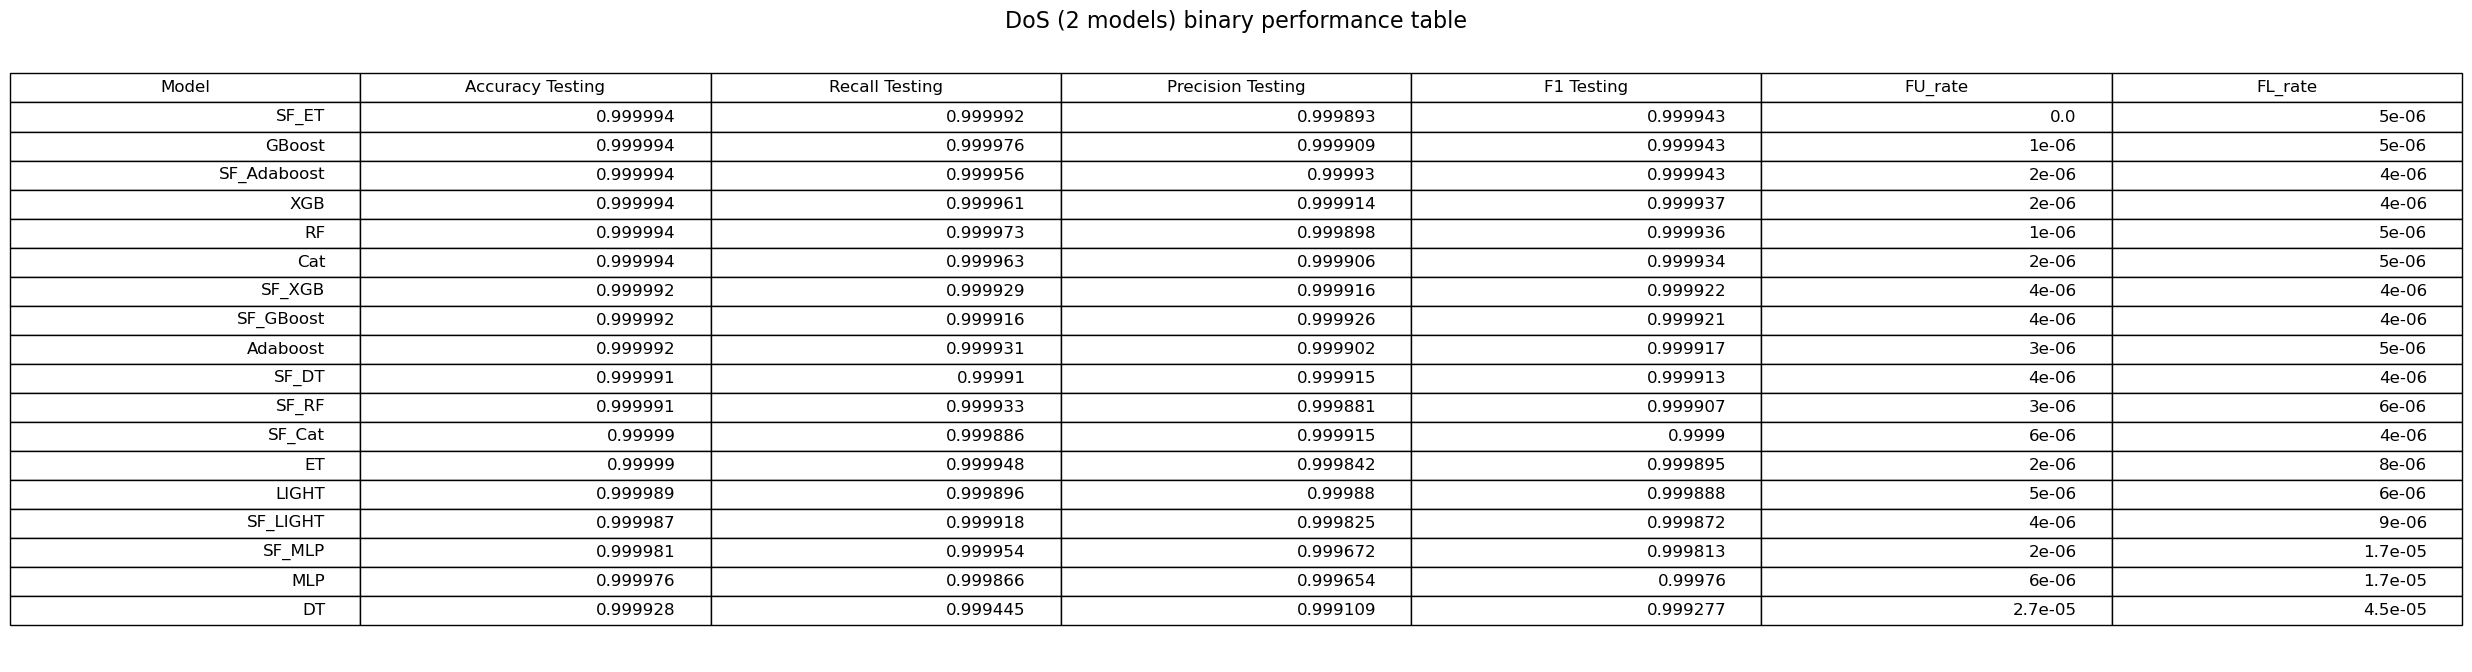

In [6]:
# Performance table
performance_table = read_csv_file(performance_path, model_path_binary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(30)
performance_table = performance_table[['Model', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate']]
performance_table = performance_table.round(6)

plot_performance_table(performance_table, model_path_binary+'Performance table.png', 'DoS (2 models) binary performance table', figsize=(25, 7))

## Do prediction for after build sets

In [5]:
# Define model
model_path = '.\\DoS_model\\Binary\\'
model = joblib.load(model_path + 'model_XGB.joblib')

try:
    # scaler = joblib.load(model_path+'scaler.joblib')
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred, z_test = get_prediction_by_model(model, after_build_sets, file_path, X_columns, y_column=z_column, z_column=y_column, scale=True, encode=True, scaler=scaler, encoder=encoder)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[z_column] = encoder.inverse_transform(y_test)
new_after_build_set_scaled['Prediction'] = encoder.inverse_transform(y_pred)
# new_after_build_set_scaled['Trinary'] = trinary_col.values
new_after_build_set_scaled[y_column] = z_test
count = len(new_after_build_set_scaled[new_after_build_set_scaled[z_column] != new_after_build_set_scaled['Prediction']])

new_after_build_set_scaled.to_csv('.\\DoS_model\\after_build_set_scaled.csv', index=False)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled) * 100,len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows'])

del new_after_build_set_scaled

res.head()

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:30<00:00,  1.62s/it]


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.999992,0.999992,0.999992,0.999992,67,0.00077,8703485


# Second model (All DoS classes)

## Building models

In [9]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    # {
    #     "Name": "Cat",
    #     "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    # },
    {
        "Name": "LIGHT",
        "Model": LGBMClassifier(random_state = 42, verbose = 0)
    },
    # {
    #     "Name": "GBoost",
    #     "Model": GradientBoostingClassifier(random_state = 42)
    # },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    # {
    #     "Name": "MLP",
    #     "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    # },
]

In [8]:
filter_name = [
    {'name': 'DoS', 'type': '='}
]
filter_cols = ['Binary']

100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


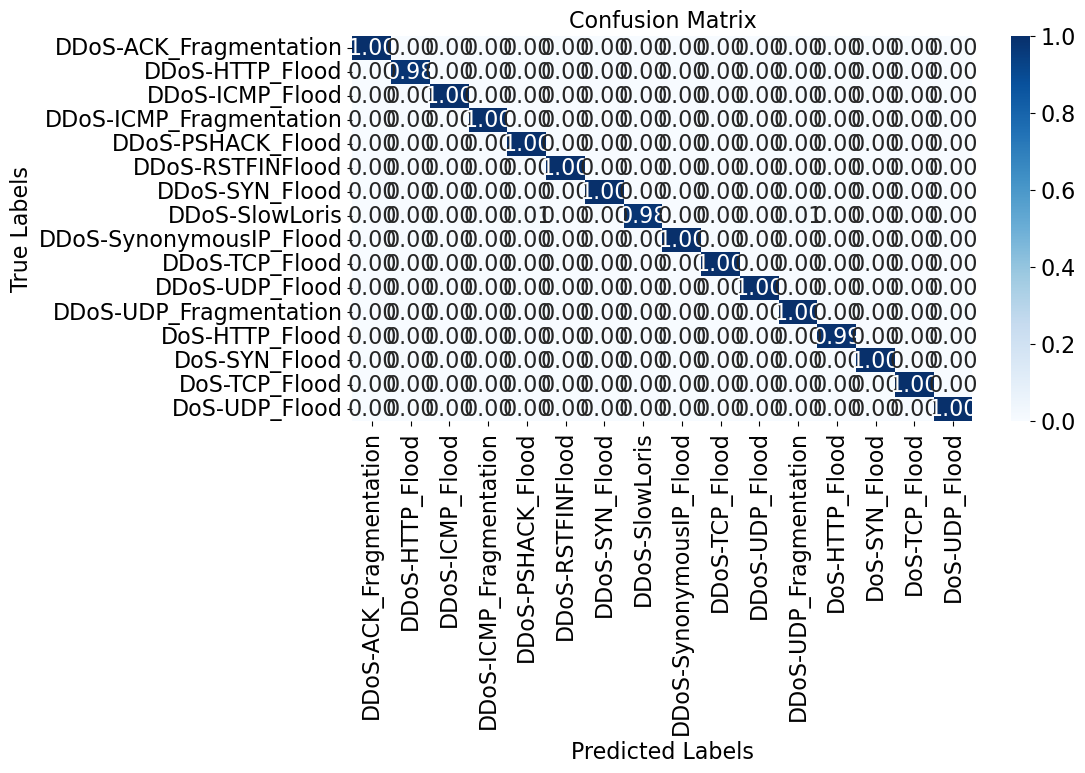

100%|██████████| 1/1 [04:02<00:00, 242.91s/it]


['.\\DoS_system_2_models\\All_classes\\encoder.joblib']

In [10]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_all_classes)
performance = get_or_define_performance_df(model_path_all_classes, performance_path)

# Load selected X columns
selected_X = pd.read_csv(model_path_all_classes+'selected_X_columns.csv').values

# Map selected X columns
selected_X = list(map(lambda x: x[0], selected_X))

# Buidling models
plotConfusionMatrix = True
figsizeConfusionMatrix = (10, 5)
saveConfusionMatrix = False
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], 'SF_' + model['Name'], train_sets, test_sets, file_path, performance, model_path_all_classes + 'SF_', X_columns=selected_X , y_column=y_column, filter_cols=filter_cols, filter_bool=True, \
                                                     filter_name=filter_name, scaler=scaler, encoder=encoder, confusionMatrix=plotConfusionMatrix, saving=saveConfusionMatrix, pathToSave=model_path_all_classes+'SF_'+model['Name'], figsize=figsizeConfusionMatrix)

    # Save performance
    performance.to_csv(model_path_all_classes + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path_all_classes+'encoder.joblib')

In [9]:
encoder = joblib.load(model_path_all_classes+'encoder.joblib')
num_classes = encoder.classes_
print("Nombre de classes :", len(num_classes), num_classes)

Nombre de classes : 16 ['DDoS-ACK_Fragmentation' 'DDoS-HTTP_Flood' 'DDoS-ICMP_Flood'
 'DDoS-ICMP_Fragmentation' 'DDoS-PSHACK_Flood' 'DDoS-RSTFINFlood'
 'DDoS-SYN_Flood' 'DDoS-SlowLoris' 'DDoS-SynonymousIP_Flood'
 'DDoS-TCP_Flood' 'DDoS-UDP_Flood' 'DDoS-UDP_Fragmentation'
 'DoS-HTTP_Flood' 'DoS-SYN_Flood' 'DoS-TCP_Flood' 'DoS-UDP_Flood']


#### Select features by importance

In [6]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": joblib.load(model_path_all_classes+'model_DT.joblib')
    },
    {
        "Name": "RF",
        "Model": joblib.load(model_path_all_classes+'model_RF.joblib')
    },
    {
        "Name": "XGB",
        "Model": joblib.load(model_path_all_classes+'model_XGB.joblib')
    },
    # {
    #     "Name": "Cat",
    #     "Model": joblib.load(model_path_all_classes+'model_Cat.joblib')
    # },
    {
        "Name": "LIGHT",
        "Model": joblib.load(model_path_all_classes+'model_LIGHT.joblib')
    },
    # {
    #     "Name": "GBoost",
    #     "Model": joblib.load(model_path_all_classes+'model_GBoost.joblib')
    # },
    {
        "Name": "Adaboost",
        "Model": joblib.load(model_path_all_classes+'model_Adaboost.joblib')
    },
]

[17:15:01] WARNING: D:\bld\xgboost-split_1679035243975\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



100%|██████████| 5/5 [00:00<00:00, 217.07it/s]


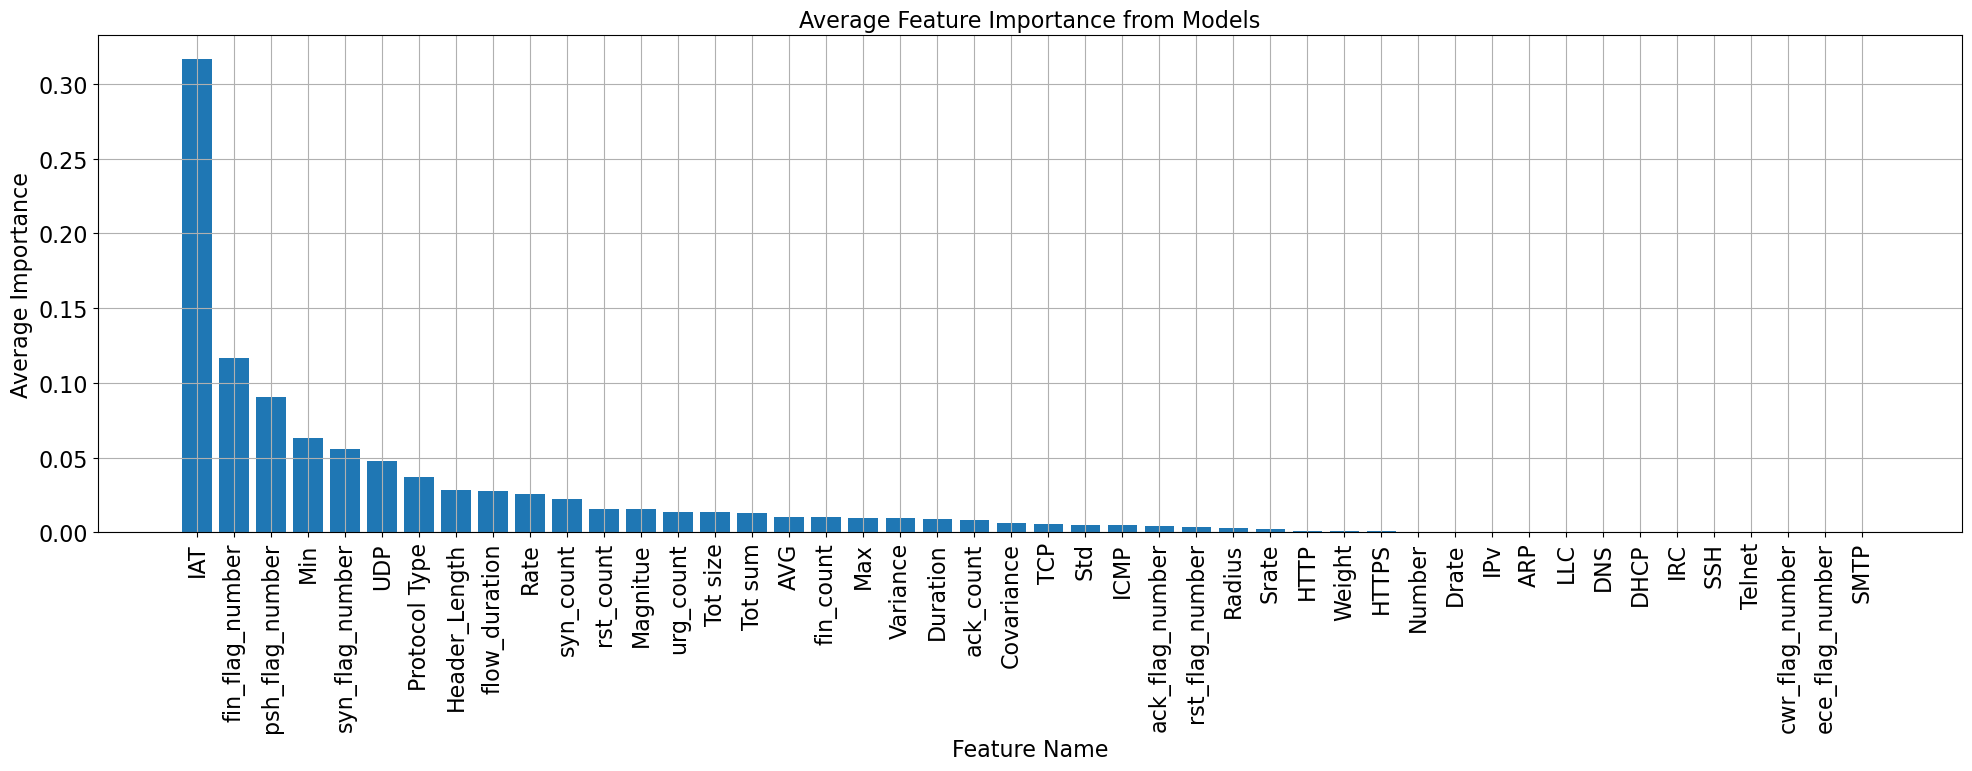

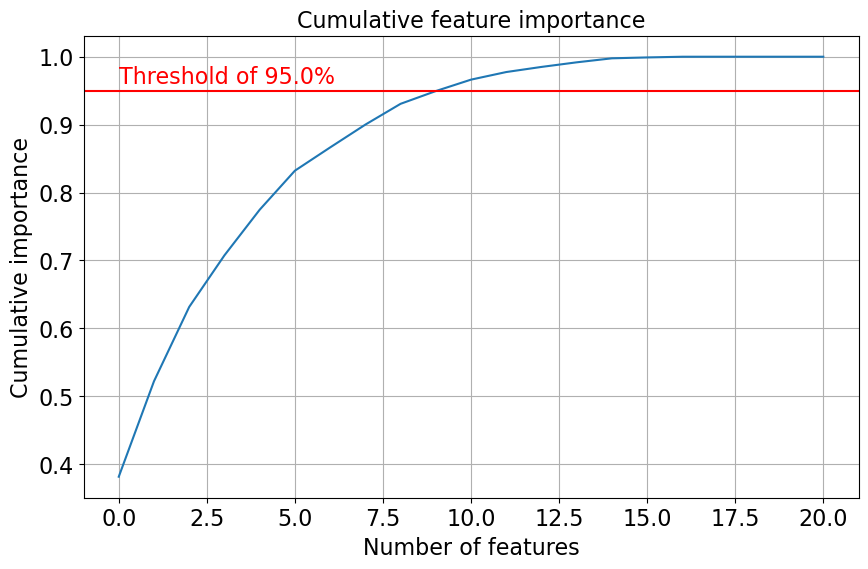

['IAT', 'fin_flag_number', 'psh_flag_number', 'Min', 'syn_flag_number', 'UDP', 'Header_Length', 'flow_duration', 'Rate', 'Magnitue']


100%|██████████| 61/61 [01:11<00:00,  1.17s/it]


In [7]:
# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, X_columns, model_path_all_classes, all_features=True, figsize=(20, 8))
average_importance_df.to_csv(model_path_all_classes+'feature_importance.csv', index=False)
average_importance_df.to_csv('.\\resultats\\DoS_2_models\\All_classes\\feature_importance.csv', index=False)

# Load feature importance dataframe
average_importance_df = pd.read_csv(model_path_all_classes+'feature_importance.csv')
# print(average_importance_df.head(average_importance_df.size))

# Remove features with correlation > 0.80
threshold = 0.80
features_with_threshold_corr = remove_features_with_correlation_and_feature_importance(read_csv_file(train_sets[0], file_path)[X_columns], average_importance_df, threshold=threshold)
# print(features_with_threshold_corr.head(features_with_threshold_corr.size))

# Select features with cumulative importance > 0.95 and correlation < 0.80
selected_X = select_features_by_importance(features_with_threshold_corr['Feature'].values, features_with_threshold_corr['Average Importance'].values, model_path_all_classes, threshold_percentage=0.95)
pd.DataFrame(selected_X).to_csv(model_path_all_classes+'selected_X_columns.csv', index=False)
print(selected_X)

# Define and fit scaler
scaler = MinMaxScaler()
for train_set in tqdm(train_sets):
    scaler.fit(read_csv_file(train_set, file_path)[selected_X])

## Display performance

In [12]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_all_classes)
performance = performance.drop(12).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path_all_classes + performance_path, index=False)

In [13]:
read_csv_file(performance_path, model_path_all_classes).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
9,SF_XGB,1.000000,1.000000,1.000000,1.000000,0.999849,0.998787,0.999202,0.998994,0.000065,0.000086,471,620,7201481
7,SF_RF,0.999998,0.999998,0.999999,0.999999,0.999690,0.996699,0.996661,0.996675,0.000169,0.000141,1220,1014,7201481
6,SF_DT,0.999999,0.999999,0.999999,0.999999,0.999678,0.996541,0.996870,0.996703,0.000144,0.000178,1035,1285,7201481
5,DT,1.000000,1.000000,1.000000,1.000000,0.999661,0.995846,0.995685,0.995765,0.000166,0.000173,1195,1243,7201481
2,XGB,0.999902,0.999912,0.999936,0.999924,0.999584,0.994265,0.992981,0.993537,0.000140,0.000275,1010,1984,7201481
0,RF,0.999983,0.999978,0.999989,0.999984,0.999131,0.992292,0.988353,0.990114,0.000458,0.000411,3300,2959,7201481
8,SF_ET,1.000000,1.000000,1.000000,1.000000,0.998451,0.981770,0.974245,0.977841,0.000970,0.000578,6989,4166,7201481
1,ET,1.000000,1.000000,1.000000,1.000000,0.997346,0.980229,0.972252,0.975277,0.001349,0.001305,9717,9396,7201481
3,LIGHT,0.529868,0.341591,0.380370,0.352775,0.913611,0.652267,0.671212,0.647037,0.046696,0.039693,336283,285848,7201481
11,SF_Adaboost,0.758227,0.586925,0.613394,0.583687,0.898552,0.717100,0.720511,0.666095,0.004570,0.096879,32909,697669,7201481


In [15]:
df=read_csv_file(performance_path, model_path_all_classes).sort_values(by=['Accuracy Testing', 'F1 Testing', 'Recall Testing', 'Precision Testing'], ascending=False).head(20)
df=df[['Accuracy Testing', 'Recall Testing','Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate', 'FU', 'FL']]

#  Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=True)

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Accuracy Testing &  Recall Testing &  Precision Testing &  F1 Testing &   FU\_rate &   FL\_rate &      FU &      FL \\
\midrule
9  &          0.999849 &        0.998787 &           0.999202 &    0.998994 &  0.000065 &  0.000086 &     471 &     620 \\
7  &          0.999690 &        0.996699 &           0.996661 &    0.996675 &  0.000169 &  0.000141 &    1220 &    1014 \\
6  &          0.999678 &        0.996541 &           0.996870 &    0.996703 &  0.000144 &  0.000178 &    1035 &    1285 \\
5  &          0.999661 &        0.995846 &           0.995685 &    0.995765 &  0.000166 &  0.000173 &    1195 &    1243 \\
2  &          0.999584 &        0.994265 &           0.992981 &    0.993537 &  0.000140 &  0.000275 &    1010 &    1984 \\
0  &          0.999131 &        0.992292 &           0.988353 &    0.990114 &  0.000458 &  0.000411 &    3300 &    2959 \\
8  &          0.998451 &        0.981770 &           0.974245 &    0.977841 &  0.000970 &  0

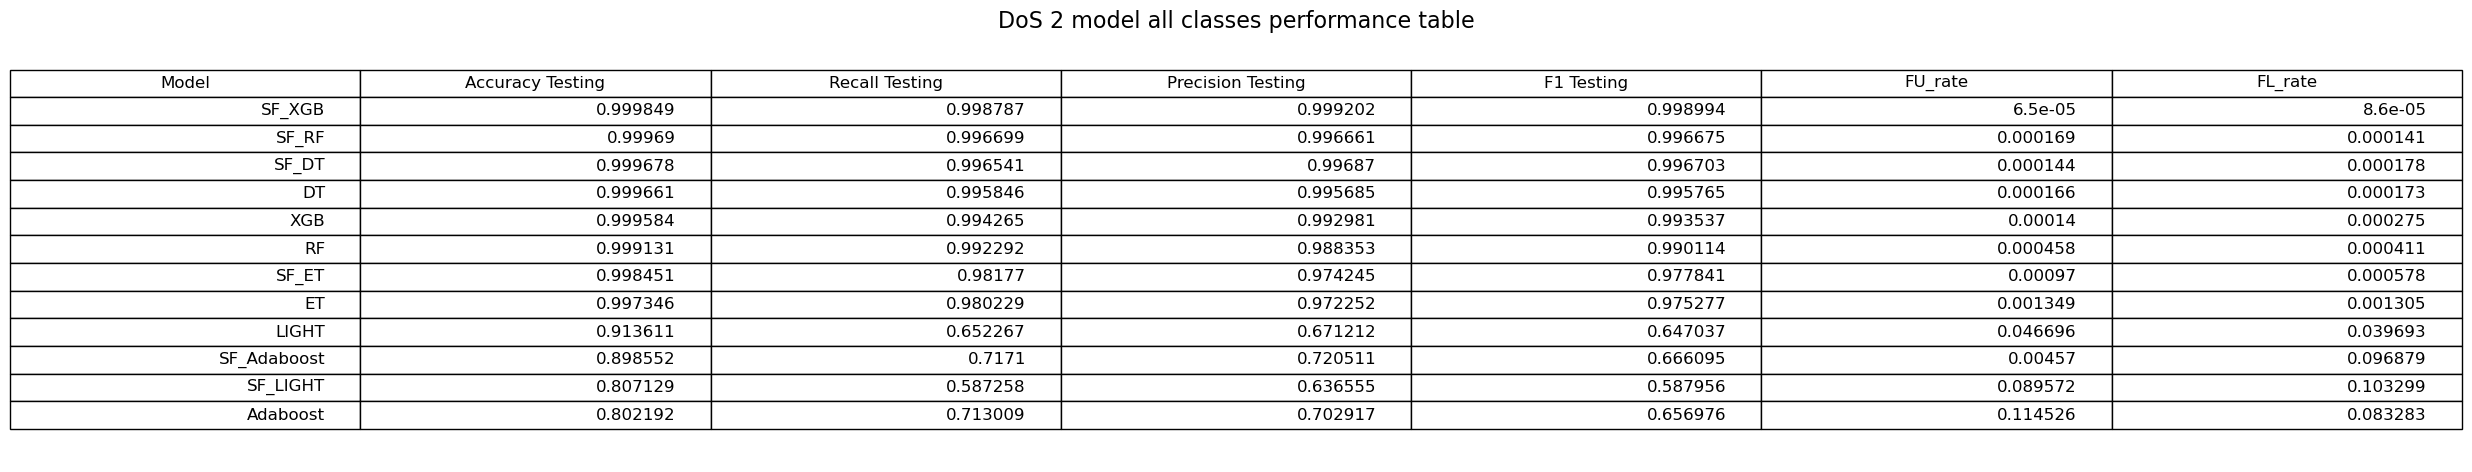

In [9]:
# Performance table
performance_table = read_csv_file(performance_path, model_path_all_classes).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(50)
performance_table = performance_table[['Model', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate']]
performance_table = performance_table.round(6)

plot_performance_table(performance_table, model_path_all_classes+'Performance table.png', 'DoS 2 model all classes performance table', figsize=(25, 5))

## Final prediction

## Tests

In [42]:
import gc
gc.collect()

406